## From which locations do players shoot in the NBA? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import imageio.v2 as imageio
from matplotlib.colors import LogNorm, TwoSlopeNorm
from matplotlib.patches import Arc, Circle
from pathlib import Path

In [2]:
# folder with data
data_folder = Path('data')

In [3]:
# loading the Dataset
relative_path = data_folder.joinpath('nba_shot_locations.csv')
shots_data = pd.read_csv(relative_path, parse_dates = ['Game Date'])

In [ ]:
# looking at the columns. Many can be dropped, as they hold the same information e.g. Shot Made Flag and Field Goal %
shots_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996375 entries, 0 to 3996374
Data columns (total 34 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   COL                      int64         
 1   Game Date                datetime64[ns]
 2   Game Event ID            int64         
 3   Game ID                  int64         
 4   Player ID                int64         
 5   Player Name              object        
 6   ROW                      int64         
 7   Season                   object        
 8   Season Text              object        
 9   Season Type              object        
 10  Season Type Filter       object        
 11  Selected Dimension       object        
 12  Selected Filter Title    object        
 13  Selected Player or Team  object        
 14  Selection Title          object        
 15  Sheet Toggle             object        
 16  Shot Made Flag           object        
 17  Shot Type                ob

In [ ]:
# filter to only include players that played 10 games or more
player_games = pd.pivot_table(shots_data, values='Game ID', index = 'Player ID', aggfunc=lambda x: len(np.unique(x))).squeeze()
selected_players = (player_games.index[player_games >= 10])

In [ ]:
# function to convert the X/Y Location to feet
def to_feet(location_series):
    return location_series / 10

In [ ]:
# Creating the actual dataset witch holds the necessary data and optimizing datatypes
shots_data_use_cols = ['Game ID', 'Player ID', 'Player Name', 'Season', 'Season Type', 'Team Name', 'X Location', 'Y Location']
shots_df = (shots_data[shots_data_use_cols]
      .assign(shot_made = shots_data['Shot Made Flag'].map({'Missed':False, 'Made':True}).astype(bool),
              shot_type = shots_data['Shot Type'].map({'2PT Field Goal': '2Pt', '3PT Field Goal':'3Pt'}).astype('category'),
              team_id = (shots_data['Team ID'] - shots_data['Team ID'].min()).astype(np.uint8),
              shot_distance = np.sqrt(np.square(to_feet(shots_data['X Location'])) + np.square(to_feet(shots_data['Y Location'])))
      )
      .astype({
          'Game ID':np.uint16,
          'Player ID': np.uint16,
          'Player Name': 'category',
          'Season': 'category',
          'Season Type': 'category',
          'Team Name': 'category',
          'X Location': np.int16,
          'Y Location': np.int16
      }
      )
    .loc[shots_data['Player ID'].isin(selected_players),]
    
)

In [ ]:
# info of the working dataframe
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3993394 entries, 0 to 3996374
Data columns (total 12 columns):
 #   Column         Dtype   
---  ------         -----   
 0   Game ID        uint16  
 1   Player ID      uint16  
 2   Player Name    category
 3   Season         category
 4   Season Type    category
 5   Team Name      category
 6   X Location     int16   
 7   Y Location     int16   
 8   shot_made      bool    
 9   shot_type      category
 10  team_id        uint8   
 11  shot_distance  float64 
dtypes: bool(1), category(5), float64(1), int16(2), uint16(2), uint8(1)
memory usage: 121.9 MB


In [ ]:
# no missing data
shots_df.isna().sum()

Game ID          0
Player ID        0
Player Name      0
Season           0
Season Type      0
Team Name        0
X Location       0
Y Location       0
shot_made        0
shot_type        0
team_id          0
shot_distance    0
dtype: int64

In [ ]:
# creating 2 subset dataframes for the 2001-02 and 20019-20 season
shots_df_1920 = shots_df.loc[shots_df['Season'] == '2019-20'] 
shots_df_0102 = shots_df.loc[shots_df['Season'] == '2001-02'] 

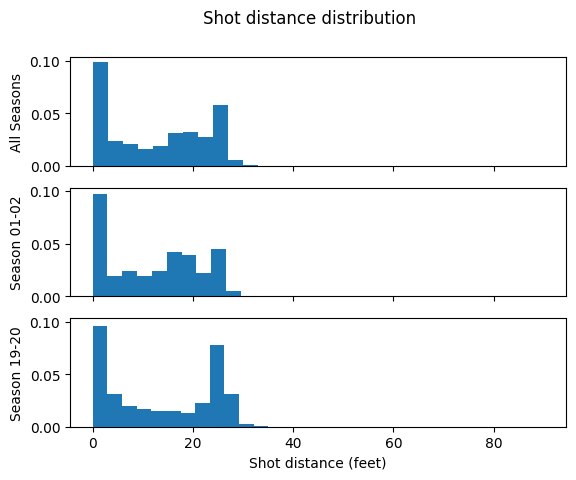

In [ ]:
# The distribution of the shot distance shows that in the 2019-20 season players take way more 3 Pt attempts rather than midrange shots.
fig, axs = plt.subplots(nrows=3, ncols=1, sharex = True, sharey=True)

axs[0].hist(shots_df.shot_distance, density = True, bins = 30)
axs[0].set_ylabel('All Seasons')
axs
axs[1].hist(shots_df_0102.shot_distance, density = True, bins = 30)
axs[1].set_ylabel('Season 01-02')
axs[2].hist(shots_df_1920.shot_distance, density = True, bins = 30)
axs[2].set_ylabel('Season 19-20')

fig.suptitle('Shot distance distribution')
plt.xlabel('Shot distance (feet)')

plt.show()

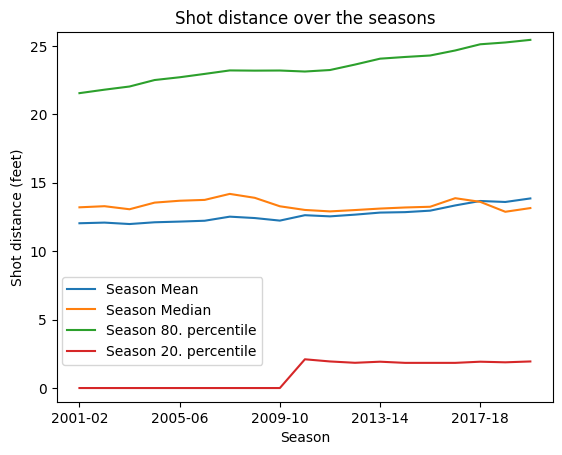

In [ ]:
# Plotting the Mean, Median, aswell as the 80 and 20 percentile of the shot distance over the seasons.
# The 80 percentile increases steadily, indicating that players take more 3Pt shots
# The 20 percentile jumps betweeen the 2009-10 and 2010-11 season, indicating that dunks became less common in the last decade.
season_mean = pd.pivot_table(shots_df, values='shot_distance', index='Season').squeeze()
season_median = pd.pivot_table(shots_df, values='shot_distance', index='Season', aggfunc='median').squeeze()
season_percentile80 = pd.pivot_table(shots_df, values='shot_distance', index='Season', aggfunc=lambda x: np.percentile(x, 80)).squeeze()
season_percentile20 = pd.pivot_table(shots_df, values='shot_distance', index='Season', aggfunc=lambda x: np.percentile(x, 20)).squeeze()

plt.plot(season_mean, label = 'Season Mean')
plt.plot(season_median, label = 'Season Median')
plt.plot(season_percentile80, label = 'Season 80. percentile')
plt.plot(season_percentile20, label = 'Season 20. percentile')

plt.ylabel('Shot distance (feet)')
plt.xlabel('Season')
plt.title('Shot distance over the seasons')

plt.xticks([0, 4, 8, 12, 16], season_mean.index.to_numpy()[[0, 4, 8, 12, 16]])

plt.ylim(-1,26)

plt.legend(loc=(0.01,0.1))
plt.show()

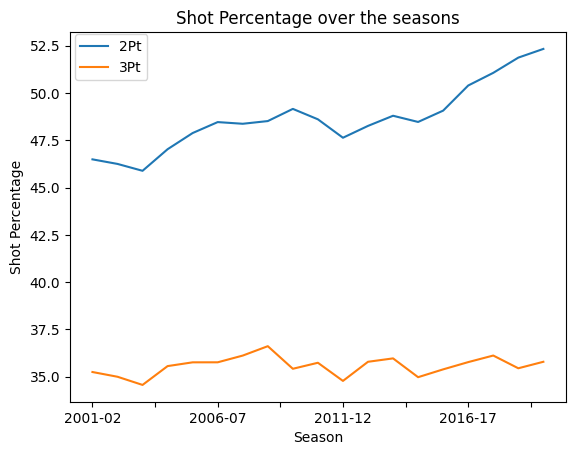

In [ ]:
# The 2Pt Shot percentage increased by rougly 10 %.
# A reason for this could be, that less midrange shots are taken (shown in future cells), and more 2Pt attempts happen around the basket.
# 3Pt percentage stayed similar
season_shots_made = pd.pivot_table(shots_df, values='shot_made', columns=['shot_type'], index='Season') * 100
season_shots_made.plot.line()

plt.ylabel('Shot Percentage')
plt.title('Shot Percentage over the seasons')

plt.legend(loc=(0.01,0.87))
plt.show()

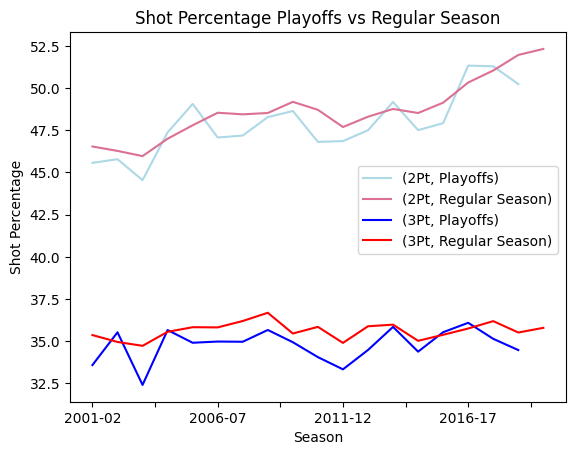

In [ ]:
# The shot percentage in the Regular season tends to be a bit higher than in the post season, but only by a slim margin 
season_shots_made = pd.pivot_table(shots_df, values='shot_made', columns=['shot_type', 'Season Type'], index='Season') * 100
season_shots_made.plot.line(color=['lightblue', 'palevioletred', 'blue', 'red'])

plt.ylabel('Shot Percentage')
plt.title('Shot Percentage Playoffs vs Regular Season')

plt.legend(loc=(0.58,0.4))
plt.show()

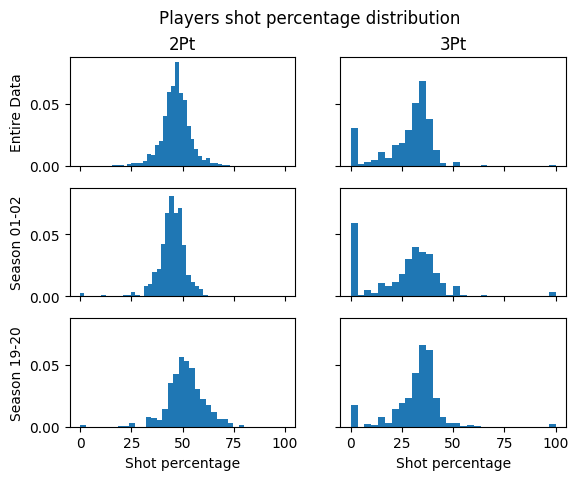

In [ ]:
# Comparison of players shot percentage distribution
# 2Pt distribution of 2019-20 shows a positive skew. Also a it is right shifted and flattenend compared to the 2001-02 season
# The 3Pt shot distributions all have a negative skew. The distribution got steeper over time.
player_distributions_all = pd.pivot_table(shots_df, values='shot_made', columns=['shot_type'], index='Player ID').squeeze() * 100
player_distributions_1920 = pd.pivot_table(shots_df_1920, values='shot_made', columns=['shot_type'], index='Player ID').squeeze() * 100
player_distributions_0102 = pd.pivot_table(shots_df_0102, values='shot_made', columns=['shot_type'], index='Player ID').squeeze() * 100

player_distributions = [player_distributions_all,player_distributions_0102, player_distributions_1920]
player_distributions_name = ['Entire Data','Season 01-02', 'Season 19-20']

fig, axs = plt.subplots(nrows=3, ncols=2, sharex = True, sharey=True)

for i, df in enumerate(player_distributions):
    axs[i, 0].hist(df['2Pt'], density = True, bins = 30)
    axs[i, 0].set_ylabel(player_distributions_name[i])
    axs[i, 1].hist(df['3Pt'], density = True, bins = 30)
    
axs[0,0].set_title('2Pt')
axs[0,1].set_title('3Pt')
axs[2,0].set_xlabel('Shot percentage')
axs[2,1].set_xlabel('Shot percentage')


fig.suptitle('Players shot percentage distribution')


plt.show()

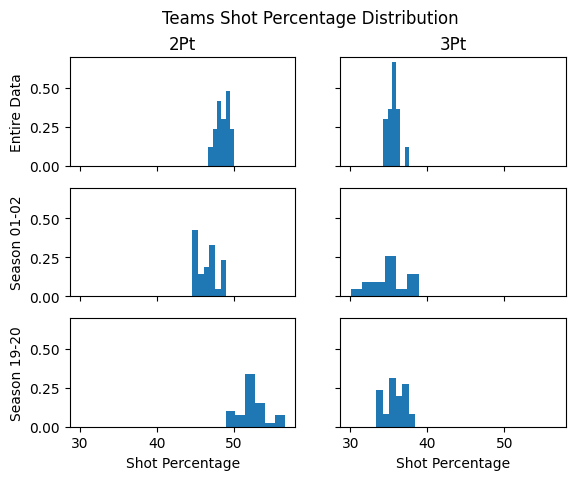

In [ ]:
# Comparison of team shot percentage distribution
# The increase in 2Pt shot percentage can be observed in the distributions
# The 3Pt distribution in the 2019-20 season is tighter than in the 2001-02 season. T
team_distributions_all = pd.pivot_table(shots_df, values='shot_made', columns=['shot_type'], index='team_id').squeeze() * 100
team_distributions_1920 = pd.pivot_table(shots_df_1920, values='shot_made', columns=['shot_type'], index='team_id').squeeze() * 100
team_distributions_0102 = pd.pivot_table(shots_df_0102, values='shot_made', columns=['shot_type'], index='team_id').squeeze() * 100


player_distributions = [team_distributions_all,team_distributions_0102, team_distributions_1920]
player_distributions_name = ['Entire Data','Season 01-02', 'Season 19-20']

fig, axs = plt.subplots(nrows=3, ncols=2, sharex = True, sharey=True)

for i, df in enumerate(player_distributions):
    axs[i, 0].hist(df['2Pt'], density = True, bins = 6)
    axs[i, 0].set_ylabel(player_distributions_name[i])
    axs[i, 1].hist(df['3Pt'], density = True, bins = 6)
    
axs[0,0].set_title('2Pt')
axs[0,1].set_title('3Pt')
axs[2,0].set_xlabel('Shot Percentage')
axs[2,1].set_xlabel('Shot Percentage')


fig.suptitle('Teams Shot Percentage Distribution')


plt.show()

In [ ]:
# Creating an new dataframe to categorize the shot locations into 1x1 feet squares. 

# creating the bins for the cut
ybins = np.arange(-50,470, 10)
ybins[0] = -52
ybins = np.append(ybins, 471)
xbins = np.arange(-250, 251, 10)
xbins[-1] = 251
# creating labels for the cut
xlabes = np.arange(0,50.0, 1)
ylabes = np.arange(0,52.0, 1)
# cutting the X and Y Locations
shots_df['X Position'] = pd.cut(shots_df['X Location'], bins = xbins, labels=xlabes, right = False)
shots_df['Y Position'] = pd.cut(shots_df['Y Location'], bins = ybins, labels=ylabes, right = False)
# creating the new df 
halfcourt_shots_df_columns = ['Season', 'Season Type', 'X Position', 'Y Position', 'shot_made']
# dropping the shots that were taken from above half court
halfcourt_shots_df = shots_df[halfcourt_shots_df_columns].dropna()
halfcourt_shots_df.info()

In [ ]:
# creating the borders of the basketball court
def create_borders(ax):
    ax.hlines(y=0.3, xmin=0, xmax=50, colors='black', lw=2)
    ax.hlines(y=52, xmin=0, xmax=50, colors='black', lw=2)
    ax.vlines(x=0.1, ymin=0, ymax=52, colors='black', lw=2)
    ax.vlines(x=49.8, ymin=0, ymax=52, colors='black', lw=2)
    return ax

# creating the field marks on the basketball court
def create_field_marks(ax):
    # Middle Circle
    ax.add_artist(Arc((25.5, 52), -12, -12, theta1=0, theta2=180, facecolor='none', edgecolor='red', lw=1))
    # 3Point Line
    ax.vlines(x=3, ymin=0, ymax=14, colors='red', lw=1)
    ax.vlines(x=47, ymin=0, ymax=14, colors='red', lw=1)
    ax.add_artist(Arc((25.1, 13.98), 44.0, 31.5, theta1=0, theta2=180, facecolor='none', edgecolor='red', lw=1))
    # Center and Circles
    ax.vlines(x=17.5, ymin=0, ymax=19, colors='red', lw=1)
    ax.vlines(x=33.5, ymin=0, ymax=19, colors='red', lw=1)
    ax.vlines(x=19.5, ymin=0, ymax=19, colors='red', lw=1)
    ax.vlines(x=31.5, ymin=0, ymax=19, colors='red', lw=1)
    ax.hlines(y=19, xmin=17.5, xmax=33.5, colors='red', lw=1)
    ax.add_artist(Circle((25.5, 19), 6, facecolor='none', edgecolor='red', lw=1))
    ax.add_artist(Arc((25.5, 5.5), 8.0, 8.0, theta1=0, theta2=180, facecolor='none', edgecolor='red', lw=1, ls='--'))
    # Backbord and basket
    ax.hlines(y=4, xmin=22, xmax=28, colors='red', lw=1)
    ax.add_artist(Circle((25.5, 5.5), 1.5, facecolor='none', edgecolor='red', lw=1))
    return ax

In [ ]:
# black color scaling
sdcmap = sns.color_palette("light:black", as_cmap=True)
# using a TwoSlopeNorm to better visualize the distribution
twoslopenorm = TwoSlopeNorm(vcenter=0.002,vmin=4e-4, vmax=0.05)
# creating dataframe with the number of shots at each position for each season
season_shotcounts = pd.pivot_table(halfcourt_shots_df, index = 'Season', values = 'shot_made', columns = ['Y Position', 'X Position'], aggfunc='count')

# the code chunck below was used to create the gif of the shot distribution heatmaps over time used in the presentation
# commented out because many pictures and plots would be saved

# for season in season_shotcounts.index:
    
#     fig, ax = plt.subplots()
#     plt.title(f'Shot distribution of the {season} season')
    
    
#     ax = create_borders(ax)
    
#     test_data = gaussian_filter(np.reshape(np.array(season_shotcounts.loc[season] / np.sum(season_shotcounts.loc[season])), (52, 50)), sigma=1)
#     sns.heatmap(test_data, vmin = 4e-4, vmax = 0.01, norm= twoslopenorm, cmap = sdcmap, xticklabels=False, yticklabels=False)
#     ax.set_xlim(0,50)
#     ax.set_ylim(0,52.5)
    
#     ax = create_field_marks(ax)
#     plt.savefig(Path('shotdistribution').joinpath(season))
#     plt.show()

# shotdistribution_plot_list = [Path('shotdistribution').joinpath(f'{season}.png') for season in season_shotcounts.index]
# with imageio.get_writer('shotdistribution.gif', mode='I', fps=1.5) as writer:
#     for plot in shotdistribution_plot_list:
#         image = imageio.imread(plot)
#         writer.append_data(image)

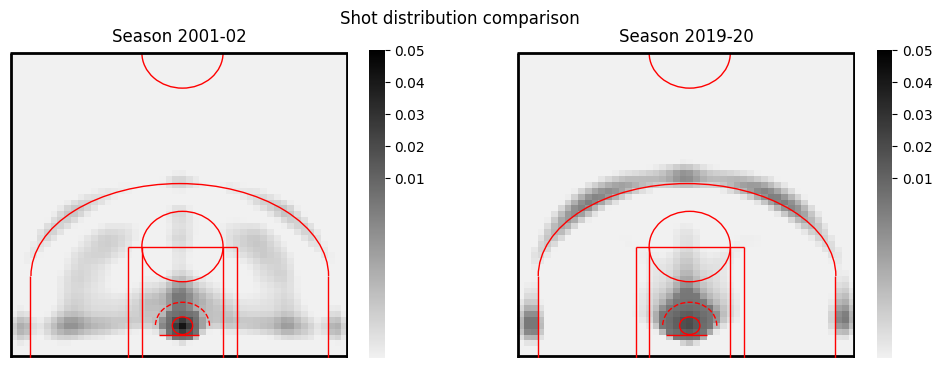

In [ ]:
# comparing the shot distribution from the 2001-02 and the 2019-20 season
# The results show that in todays nba less mid range shots are taken, but more 3Pt attempts
# Also the number of dunks decreased
fig, axs = plt.subplots(1,2, figsize=(12, 4))
fig.suptitle(f'Shot distribution comparison')

ax1 = create_borders(axs[0])
ax2 = create_borders(axs[1])

test_data = gaussian_filter(np.reshape(np.array(season_shotcounts.loc['2001-02'] / np.sum(season_shotcounts.loc['2001-02'])), (52, 50)), sigma=1)
sns.heatmap(test_data, vmin = 4e-4, vmax = 0.01, norm= twoslopenorm, cmap = sdcmap, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_xlim(0,50)
ax1.set_ylim(0,52.5)
ax1.set_title('Season 2001-02')
ax1 = create_field_marks(ax1)



test_data = gaussian_filter(np.reshape(np.array(season_shotcounts.loc['2019-20'] / np.sum(season_shotcounts.loc['2019-20'])), (52, 50)), sigma=1)
sns.heatmap(test_data, vmin = 4e-4, vmax = 0.01, norm= twoslopenorm, cmap = sdcmap, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_xlim(0,50)
ax2.set_ylim(0,52.5)
ax2.set_title('Season 2019-20')
ax2 = create_field_marks(ax2)

plt.show()

In [ ]:
# green color scaling
spcmap = sns.color_palette("light:green", as_cmap=True)
# creating dataframe with the count of made shots at each position for each season
season_shotpercent = pd.pivot_table(halfcourt_shots_df, index = 'Season', values = 'shot_made', columns = ['Y Position', 'X Position'], aggfunc='sum')
# converting the dataframe from above to percentages and filling missing values with 0 to enable the use of gaussian_filters
season_shotpercent = season_shotpercent.divide(season_shotcounts).fillna(0) * 100

# the code chunck below was used to create the gif of the shotpercentage heatmaps over time used in the presentation
# commented out because many pictures and plots would be saved

# for season in season_shotcounts.index:   
#     fig, ax = plt.subplots()
#     plt.title(f'Shot percentage of the {season} season')
    
    
#     ax = create_borders(ax)
    
#     test_data = gaussian_filter(np.reshape(np.array(season_shotpercent.loc[season]), (52, 50)), sigma=1)
#     sns.heatmap(test_data, vmin = 20, vmax = 100, cmap = spcmap, xticklabels=False, yticklabels=False)
#     ax.set_xlim(0,50)
#     ax.set_ylim(0,52.5)
    
#     ax = create_field_marks(ax)
#     plt.savefig(Path('shotpercent').joinpath(season))
#     plt.show()

# shotpercent_plot_list = [Path('shotpercent').joinpath(f'{season}.png') for season in season_shotcounts.index]
# with imageio.get_writer('shotpercent.gif', mode='I', fps=1.5) as writer:
#     for plot in shotpercent_plot_list:
#         image = imageio.imread(plot)
#         writer.append_data(image)

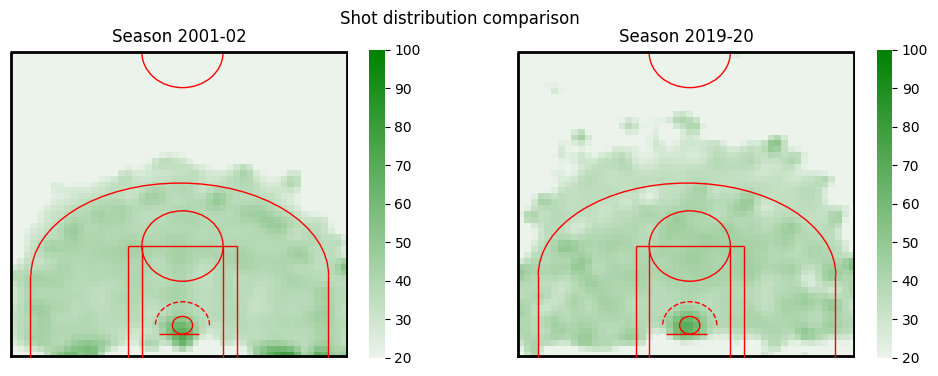

In [ ]:
# comparing the shot percentage from the 2001-02 and the 2019-20 season
# The shot percentage in certain areas changed, however, this is most likely due to little data in some of the suqres at near the lines.
# The plots also seem to indicate that more 3Pt attempts were taken from far beyond the 3 Point line.
fig, axs = plt.subplots(1,2, figsize=(12, 4))
fig.suptitle(f'Shot distribution comparison')

ax1 = create_borders(axs[0])
ax2 = create_borders(axs[1])

test_data = test_data = gaussian_filter(np.reshape(np.array(season_shotpercent.loc['2001-02']), (52, 50)), sigma=1)
sns.heatmap(test_data, vmin = 20, vmax = 100, cmap = spcmap, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_xlim(0,50)
ax1.set_ylim(0,52.5)
ax1.set_title('Season 2001-02')
ax1 = create_field_marks(ax1)



test_data = test_data = gaussian_filter(np.reshape(np.array(season_shotpercent.loc['2019-20']), (52, 50)), sigma=1)
sns.heatmap(test_data, vmin = 20, vmax = 100, cmap = spcmap, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_xlim(0,50)
ax2.set_ylim(0,52.5)
ax2.set_title('Season 2019-20')
ax2 = create_field_marks(ax2)

plt.show()

#### Conclusion:
Although three-point field goals are becoming more popular, the effectiveness stayed consistent throughout the seasons at 35-36%. However, the difference between teams decreased. Between the seasons 2001-02 and 2019-20, the IQR of teams' 3-point field goal percentage almost halved from 3.6% to 1.9%. We also found that the 2-point shooting percentage increased from 46% to 52% percent.
In summary, the game moved away from mid-range shots, leading to more 3-point attempts and a higher 2-point shooting percentage. Differences between teams are getting smaller and shots are taken from a higher range.


## How have the physical characteristics of NBA players changed over the years?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# loading the Dataset
relative_path = data_folder.joinpath('all_seasons.csv')
nba = pd.read_csv(relative_path)

We loaded the data and decided to do some processing of it. We removed all the players that played less than 10 games each season because they were not significant factors in the league in that season (could be some players that had only 10 days contracts or injured players). After that, Iwe combined two advanced statistical parameters, oreb_pct and dreb_pct into a single column, which is rebound_pct and we got that column by just summing values of offensive and defensive rebound percentage for each row.

In [ ]:
nba = nba[nba['gp'] >= 10]
nba = nba.drop('Unnamed: 0', axis=1)
nba = nba.reset_index(drop=True)

In [ ]:
nba = nba.assign(rebound_pct = nba['oreb_pct'] + nba['dreb_pct'])
nba = nba.drop(['oreb_pct', 'dreb_pct'], axis=1)
nba

player_name team_abbreviation   age  player_height  \
0          Dennis Rodman               CHI  36.0         198.12   
1      Dwayne Schintzius               LAC  28.0         215.90   
2            Ed O'Bannon               DAL  24.0         203.20   
3            Ed Pinckney               MIA  34.0         205.74   
4          Eddie Johnson               HOU  38.0         200.66   
...                  ...               ...   ...            ...   
11180      Markus Howard               DEN  23.0         177.80   
11181    Markieff Morris               MIA  32.0         205.74   
11182     Markelle Fultz               ORL  24.0         193.04   
11183       Marcus Smart               BOS  28.0         193.04   
11184     Marcus Garrett               MIA  23.0         195.58   

       player_weight                      college country draft_year  \
0          99.790240  Southeastern Oklahoma State     USA       1986   
1         117.933920                      Florida     USA       1990   
2         100.697424                         UCLA     USA       1995   
3         108.862080                    Villanova     USA       1985   
4          97.522280                     Illinois     USA       1981   
...              ...                          ...     ...        ...   
11180      79.378600                    Marquette     USA  Undrafted   
11181     111.130040                       Kansas     USA       2011   
11182      94.800728                   Washington     USA       2017   
11183      99.790240               Oklahoma State     USA       2014   
11184      92.986360                       Kansas     USA  Undrafted   

      draft_round draft_number  gp   pts   reb  ast  net_rating  usg_pct  \
0               2           27  55   5.7  16.1  3.1        16.1    0.100   
1               1           24  15   2.3   1.5  0.3        12.3    0.175   
2               1            9  64   3.7   2.3  0.6        -8.7    0.167   
3               1           10  27   2.4   2.4  0.2       -11.2    0.127   
4               2           29  52   8.2   2.7  1.0         4.1    0.220   
...           ...          ...  ..   ...   ...  ...         ...      ...   
11180   Undrafted    Undrafted  31   4.1   0.4  0.2        -4.9    0.264   
11181           1           13  17   7.6   2.6  1.4         4.5    0.197   
11182           1            1  18  10.8   2.7  5.5        -5.3    0.265   
11183           1            6  71  12.1   3.8  5.9         9.3    0.179   
11184   Undrafted    Undrafted  12   1.1   1.9  0.6         5.8    0.086   

       ts_pct  ast_pct   season  rebound_pct  
0       0.479    0.113  1996-97        0.509  
1       0.430    0.048  1996-97        0.229  
2       0.399    0.077  1996-97        0.209  
3       0.611    0.040  1996-97        0.288  
4       0.541    0.102  1996-97        0.160  
...       ...      ...      ...          ...  
11180   0.567    0.068  2021-22        0.074  
11181   0.547    0.116  2021-22        0.148  
11182   0.517    0.448  2021-22        0.126  
11183   0.540    0.245  2021-22        0.111  
11184   0.280    0.069  2021-22        0.180  

[11185 rows x 20 columns]

In [ ]:
result = nba.dtypes

In [ ]:
result

player_name           object
team_abbreviation     object
age                  float64
player_height        float64
player_weight        float64
college               object
country               object
draft_year            object
draft_round           object
draft_number          object
gp                     int64
pts                  float64
reb                  float64
ast                  float64
net_rating           float64
usg_pct              float64
ts_pct               float64
ast_pct              float64
season                object
rebound_pct          float64
dtype: object

Here we made an analysis of the mean height and weight for all the players that played in the league from 1996-97 to 2021-22 and we also plotted it. The mean values are highlighted with black vertical line on both graphs, density plot is marked with red line and data is divided in the bins so that we can visualise the percentage of players having certain amount of centimeters and kilos in each group. 

In [ ]:
player_height_mean = np.mean(nba['player_height'])
player_weight_mean = np.mean(nba['player_weight'])

print("Mean player height:", player_height_mean)
print("Mean player weight:", player_weight_mean)

Mean player height: 200.68357979436743
Mean player weight: 100.52066029432275


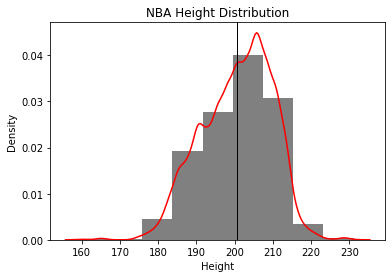

In [ ]:
# Plot histogram
plt.hist(nba['player_height'], density=True, color='grey', alpha=1, bins=9)

# Plot density plot
sns.kdeplot(nba['player_height'], color='red')

# Add vertical line for mean
plt.axvline(nba['player_height'].mean(), color='black', linewidth=1)

# Add plot labels
plt.xlabel('Height')
plt.ylabel('Density')
plt.title('NBA Height Distribution')

plt.show()

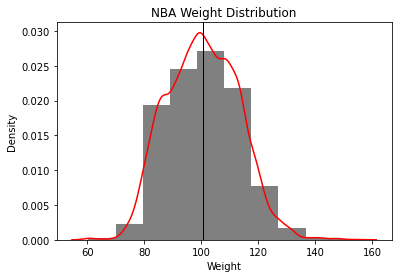

In [ ]:
plt.hist(nba['player_weight'], density=True, color='grey', alpha=1, bins=10)

# Plot density plot
sns.kdeplot(nba['player_weight'], color='red')

# Add vertical line for mean
plt.axvline(nba['player_weight'].mean(), color='black', linewidth=1)

# Add plot labels
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('NBA Weight Distribution')

plt.show()

We performed a regression model for every season and we see that the model is somewhat similar for each season, attributes of players haven't changed much throughout the years.

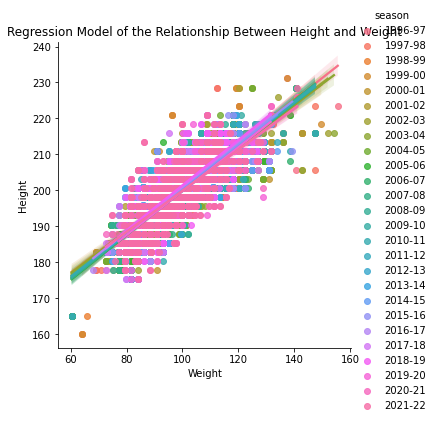

In [ ]:
sns.lmplot(x='player_weight', y='player_height', data=nba, hue='season', fit_reg=True)

# Add plot title and axis labels
plt.title('Regression Model of the Relationship Between Height and Weight')
plt.xlabel('Weight')
plt.ylabel('Height')

plt.show()

Grouping data by season and getting a mean values for player height and weight seemed like a good strategy to explore trends in the last 25 years so we did that and then visualised it, as we can see things haven't changed too much up until 2018, when there is a big decline in mean height in NBA (almost 1.5 cms which is a huge number actually) and weight just started to drop below 100 kg since 2016 and ever since then, players are becoming even lighter.

In [ ]:
nba2 = nba.groupby('season').mean()[['player_height', 'player_weight']]
print(nba2)

         player_height  player_weight
season                               
1996-97     200.996559     100.589509
1997-98     200.640758     100.500409
1998-99     200.807831     100.678224
1999-00     201.006650     101.001319
2000-01     200.863709     100.970261
2001-02     201.113350     101.610153
2002-03     201.413766     101.943954
2003-04     201.228657     101.567373
2004-05     201.280094     101.739834
2005-06     200.760419     101.187936
2006-07     200.642155     101.345413
2007-08     200.526316     100.643167
2008-09     201.125157     101.149923
2009-10     200.989736     101.261529
2010-11     201.224717     101.594243
2011-12     200.819402     101.065715
2012-13     200.947018     101.008812
2013-14     200.892636     100.632798
2014-15     200.980615     100.578701
2015-16     201.109252     100.568855
2016-17     201.002472      99.968619
2017-18     200.605726      99.164128
2018-19     200.752068      98.928512
2019-20     199.086304      98.832766
2020-21     

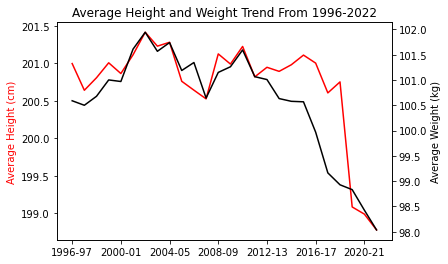

In [ ]:
fig, ax1 = plt.subplots()

# Plot average height
ax1.plot(nba2['player_height'], color='red')

# Set y-axis label
ax1.set_ylabel('Average Height (cm)', color='red')

# Create second y-axis
ax2 = ax1.twinx()

# Plot average weight
ax2.plot(nba2['player_weight'], color='black')

# Set y-axis label
ax2.set_ylabel('Average Weight (kg)', color='black')

# Set plot title
plt.title('Average Height and Weight Trend From 1996-2022')

# Set tick locations and labels
plt.xticks(range(0, len(nba2.index), 4), nba2.index[range(0, len(nba2.index), 4)], rotation=45)

plt.show()

#### Conclusion:
The NBA data we collected can be divided into 2 phases: the first lasts about 15-20 years and is characterized by the presence of big men (taller than 205 cm) and the small-ball trend in basketball that started about 6 years ago. The small-ball trend in the NBA refers to a style of play that emphasizes speed, quickness, and outside shooting over traditional big men and physicality. We hypothesized to investigate whether this trend has led to a shift in the physical characteristics of players, with teams now favoring smaller, faster, more versatile players over larger, bulkier players.
Trends in average height and weight from 1996 to 2022 support the idea that players today are smaller and lighter. In 1996, the average body measurements were 201 cm and 100.5 kg; in 2022, they were 198.8 cm and 98 kg. When using the imperial measurement system, tall players are considered to be about 6-8, or about 205cm in the metric system. We examined the percentage of players taller than 205cm in all seasons for which we had data, and the results were quite surprising: from 41% of players taller than 205cm in 1996, this percentage dropped to only 26% of players in 2022, confirming the hypothesis we made at the beginning. Considering that basketball is a sport characterized by its physical characteristics that cannot be learned, we wanted to see how the outliers change over the seasons: We selected the 10 tallest players in each season and compared their average height across seasons. Again, we find that the average height of the tallest players in 2022 is about 3.5cm shorter than the players who played in 1996. 
In summary, our analysis of NBA data over the past 25 years has shown that players' physical characteristics have changed significantly, and players have become smaller and lighter over time. These findings have significant implications for the future of the game and player recruitment and development.



## How are physical characteristics correlated with player statistics?

Now we performed Pearson correlation. We took some of the columns that seemed interesting and by using heatmap we tried to see how these variables correlate with each other. The biggest correlation is, expectedly, between height and weight, of course assists and assist percentage have a high correlation because they represent almost the same thing and same thing is with rebounds and rebound percentage, although in a slightly lower correlation. Things that also caught my eyes as expected is that there is a positive correlation between usage percentage and points and that there is a negative correlation between height and assists (smaller players are mostly playmakers and they have higher numbers of assists).

<AxesSubplot: >

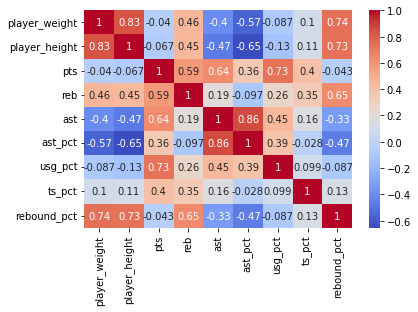

In [ ]:
corr = nba[['player_weight', 'player_height', 'pts', 'reb', 'ast', 'ast_pct', 'usg_pct', 'ts_pct', 'rebound_pct']].corr(method='pearson')

# Visualize correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')

One thing that interested me is how the percentage of assists changed through the years with new trends. If tall players are one-dimensional nowadays they can't accomplish too much, so now it is also expected from them to be able to distribute the ball and keep the offense flowing. That's why we grouped players by height (we choose height of 205cm, which is a normal height for most forwards and all centers are taller than that so it was a good distinction between forward/center positions and guard positions). As we can see, from approximately 2015 taller players are becoming much more engaged in assist percentage showing the growing trend inside the league, and we analyzed one player who is a huge anomaly and who is bringing a lot of his impact on this growth.

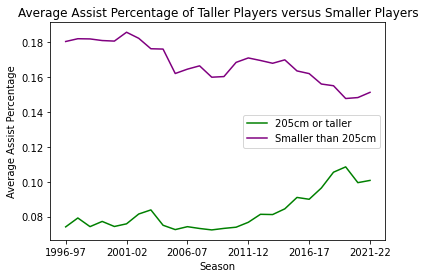

In [ ]:
nba3 = nba[nba['player_height'] >= 205.00]

# Group by season and compute mean ts_pct
nba3 = nba3.groupby('season').mean()['ast_pct']

# Filter rows where player height is less than 205 cm
nba4 = nba[nba['player_height'] < 205.00]

# Group by season and compute mean ts_pct
nba4 = nba4.groupby('season').mean()['ast_pct']

# Join nba3 and nba4 on season
nba5 = pd.merge(nba3, nba4, on='season')
nba5 = nba5.reset_index()

# Set colors
colors = {'205cm or taller': 'green', 'Smaller than 205cm': 'purple'}

# Plot line chart
nba5.plot(x='season', kind='line', color=list(colors.values()))

# Add legend and labels
plt.legend(list(colors.keys()))
plt.xlabel('Season')
plt.ylabel('Average Assist Percentage')
plt.title('Average Assist Percentage of Taller Players versus Smaller Players')

plt.show()

We wanted to analyze how the min, max and mean height changed in one team throughout the year and plot it. We picked Los Angeles Lakers and as we can see, there is a big change between years when it comes to tallest players (their tallest player last season was only 208cm), which also bring a lot of change to mean height, but again this can heavily depend on a team and how they picked their rosters.

                          player_height                    
                                    min     max        mean
season  team_abbreviation                                  
1996-97 LAL                      185.42  215.90  202.613846
1997-98 LAL                      185.42  215.90  202.141667
1998-99 LAL                      182.88  215.90  201.441538
1999-00 LAL                      185.42  215.90  202.809231
2000-01 LAL                      182.88  215.90  200.297143
2001-02 LAL                      185.42  215.90  201.832308
2002-03 LAL                      185.42  215.90  201.930000
2003-04 LAL                      185.42  215.90  202.655714
2004-05 LAL                      180.34  215.90  202.474286
2005-06 LAL                      193.04  213.36  202.723750
2006-07 LAL                      185.42  213.36  201.022857
2007-08 LAL                      185.42  213.36  203.538667
2008-09 LAL                      185.42  213.36  203.200000
2009-10 LAL                      185.42 

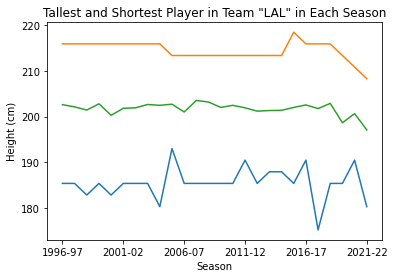

In [ ]:
nba8 = nba[nba['team_abbreviation'] == "LAL"]

# Group by season, team_abbreviation, and compute the maximum and minimum height for each group
nba8 = nba8.groupby(['season', 'team_abbreviation']).agg({'player_height': ['min', 'max', 'mean']})
print(nba8)

# Reset index
nba8 = nba8.reset_index()
nba8.plot(x='season', kind='line', legend=None)
plt.xlabel('Season')
plt.ylabel('Height (cm)')
plt.title('Tallest and Shortest Player in Team "LAL" in Each Season')

plt.show()

We wanted to explore one big anomaly involving centers. Nikola Jokic is a player that is nothing like we have ever seen before, with his playmaking skills being one of the best in history despite him being the center. As we see, his assistant percentage is ridiculous when compared to other players of his size.

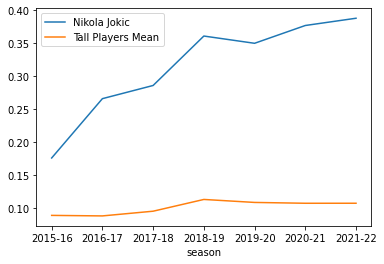

In [ ]:
jokic_stats = nba.loc[nba['player_name'] == 'Nikola Jokic']
tall_players = nba.loc[(nba['player_height'] >= 210) & (nba['season'] >= '2015-16')]
tall_players_mean = tall_players.groupby('season')['ast_pct'].mean()
jokic_stats.plot(x='season', y='ast_pct', label='Nikola Jokic')
tall_players_mean.plot(x='season', y='ast_pct', label='Tall Players Mean')
plt.legend()
plt.show()

As we already mentioned, smallball is a new trend in the league which means that tall players have to be more versatile than ever before, and we wanted to check how the percentage of players taller than 205cm changed over time. Results are pretty shocking - their numbers being higher than 40% thorughout the first 15-20 years, and then there is a huge decline, resulting in only approximately 1/4 of players in the league being taller than 205cm. 

In [ ]:
nba_grouped_by_season = nba.groupby('season')

# Compute the percentage of players taller than 205cm in each season
tall_players_pct = nba_grouped_by_season.apply(lambda x: (x['player_height'] > 205).mean())

# Print the result
print(tall_players_pct)

season
1996-97    0.411471
1997-98    0.409091
1998-99    0.420635
1999-00    0.424318
2000-01    0.418546
2001-02    0.437653
2002-03    0.436409
2003-04    0.417910
2004-05    0.420188
2005-06    0.406977
2006-07    0.407494
2007-08    0.392344
2008-09    0.419277
2009-10    0.417266
2010-11    0.429245
2011-12    0.406897
2012-13    0.415138
2013-14    0.420455
2014-15    0.413187
2015-16    0.405896
2016-17    0.397753
2017-18    0.371795
2018-19    0.360341
2019-20    0.271739
2020-21    0.271429
2021-22    0.262000
dtype: float64


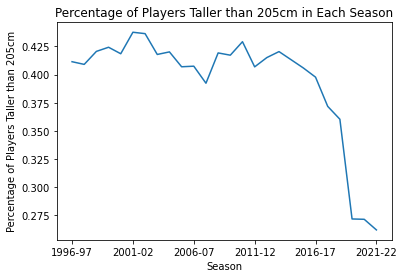

In [ ]:
tall_players_pct.plot(kind='line')

# Add labels
plt.xlabel('Season')
plt.ylabel('Percentage of Players Taller than 205cm')
plt.title('Percentage of Players Taller than 205cm in Each Season')

# Show the plot
plt.show()

After that surprising relevation, we wanted to do another heatmap correlations divided into 2, before and after 2015-16 season, where most of the changes started, and results changed a bit. As we see, height and weight are still negatively correlated with assists, but in a lot smaller number than before, which shows that taller players also have to provide for their team and play as playmakers sometimes. We can also see that true shooting percentage changed quite a lot with player height and weight, and we think that explanation for that is that advanced statistics in the NBA changed and evolved quite a lot in the last couple of years, and they are very biased towards taller players and their efficiency.

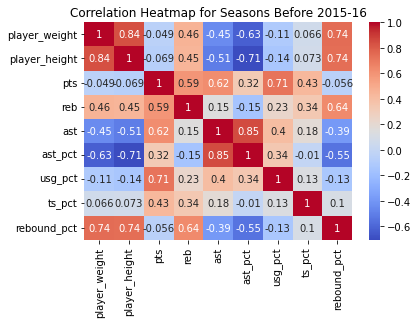

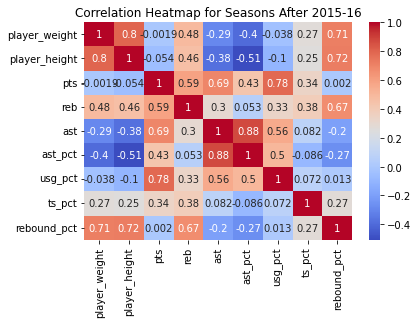

In [ ]:
# Create data frames for seasons before and after 2015-16
before_2015_16 = nba[nba['season'] < '2015-16']
after_2015_16 = nba[nba['season'] >= '2015-16']

# Select relevant columns for the heatmaps
before_2015_16_subset = before_2015_16[['player_weight', 'player_height', 'pts', 'reb', 'ast', 'ast_pct', 'usg_pct', 'ts_pct', 'rebound_pct']]
after_2015_16_subset = after_2015_16[['player_weight', 'player_height', 'pts', 'reb', 'ast', 'ast_pct', 'usg_pct', 'ts_pct', 'rebound_pct']]

# Calculate correlations for the seasons before 2015-16
corr_before = before_2015_16_subset.corr()

# Create heatmap for the seasons before 2015-16
sns.heatmap(corr_before, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Seasons Before 2015-16')
plt.show()

# Calculate correlations for the seasons after 2015-16
corr_after = after_2015_16_subset.corr()

# Create heatmap for the seasons after 2015-16
sns.heatmap(corr_after, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Seasons After 2015-16')
plt.show()

We wanted to also check how the height changed for players entering the draft. Most of young players that are entering the league thorugh NBA draft are between 18 and 22, so the mean height of young players will also show us new trends and what kind of players are sought after nowadays. We can see that in the last couple of years smaller players are more dominant and this is the first time in history that players shorter than 200cm are becoming more prevalent in the NBA. Truly remarkable and game changing era.

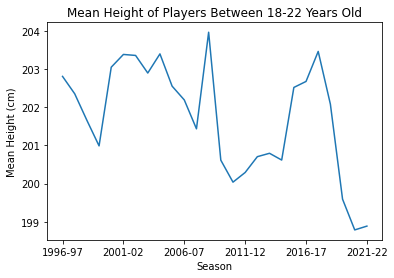

In [ ]:
young_players = nba.loc[(nba['age'] >= 18) & (nba['age'] <= 22)]
mean_height_by_season = young_players.groupby('season')['player_height'].mean()
mean_height_by_season.plot()
plt.xlabel('Season')
plt.ylabel('Mean Height (cm)')
plt.title('Mean Height of Players Between 18-22 Years Old')
plt.show()

One common misconception that someone who doesn't follow NBA can have is that the tallest players will always pick up the most rebounds. Although there is a good logic behind that way of thinking, rebounding is way more than just physical tools - one could argue that positioning is the most important aspect of rebounding. Here we took rebounding percentage of the tallest player and the highest percentage player in each season and compared them on the graph. As we can see, tallest player is not necessarily the best rebounder, although they mostly ranked pretty highly in the rankings, but never at the top.

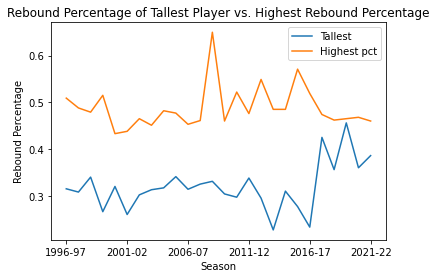

In [ ]:
nba_grouped = nba.groupby('season')

# Initialize empty lists for tallest player's rebound_pct and highest rebound_pct
tallest_rebound_pct = []
highest_rebound_pct = []

# Loop through each group (i.e., each season)
for name, group in nba_grouped:
    # Find the index of the tallest player in the group
    tallest_index = group[group['player_height'] == group['player_height'].max()].index[0]
    # Find the index of the player with the highest rebound_pct in the group
    highest_index = group['rebound_pct'].idxmax()
    # Append the rebound_pct of the tallest player and the highest rebound_pct to the lists
    tallest_rebound_pct.append(group.loc[tallest_index, 'rebound_pct'])
    highest_rebound_pct.append(group.loc[highest_index, 'rebound_pct'])

# Create a new data frame with the tallest player's rebound_pct and highest rebound_pct
rebound_pct_df = pd.DataFrame({'tallest': tallest_rebound_pct, 'highest': highest_rebound_pct}, index=nba_grouped.groups.keys())

# Plot the data
rebound_pct_df.plot(y=['tallest', 'highest'], label=['Tallest', 'Highest pct'])
plt.xlabel('Season')
plt.ylabel('Rebound Percentage')
plt.title('Rebound Percentage of Tallest Player vs. Highest Rebound Percentage')
plt.legend()
plt.show()

In the following 5 graphs, we selected top 10 scorers, rebounders, assistants, usagers and true shooters and compared their height and weight throughout all the seasons. We see there were a lot of changes in these 26 years which correlate to all the trends that we mentioned earlier.

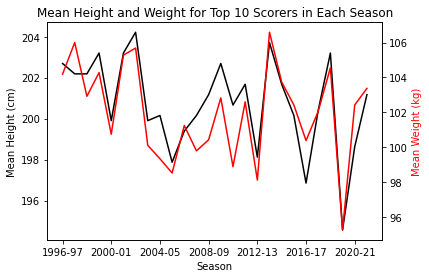

In [ ]:
top_10_players = nba.sort_values(by='pts', ascending=False).groupby('season').head(10)
fig, ax1 = plt.subplots()

# Plot the mean height for top 10 scorers on the first y-axis
mean_height = top_10_players.groupby('season')['player_height'].mean()
ax1.plot(mean_height, color='black', label='Mean Height')
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Height (cm)', color='black')

# Create a second y-axis on the same plot
ax2 = ax1.twinx()

# Plot the mean weight for top 10 scorers on the second y-axis
mean_weight = top_10_players.groupby('season')['player_weight'].mean()
ax2.plot(mean_weight, color='r', label='Mean Weight')
ax2.set_ylabel('Mean Weight (kg)', color='r')

# Add a title and a legend to the plot
x_ticks = mean_height.index[::4]
plt.xticks(x_ticks, mean_height.index[::4])
plt.title('Mean Height and Weight for Top 10 Scorers in Each Season')

# Show the plot
plt.show()

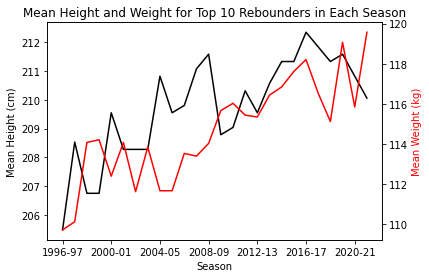

In [ ]:
top_10_players = nba.sort_values(by='rebound_pct', ascending=False).groupby('season').head(10)
fig, ax1 = plt.subplots()

# Plot the mean height for top 10 scorers on the first y-axis
mean_height = top_10_players.groupby('season')['player_height'].mean()
ax1.plot(mean_height, color='black', label='Mean Height')
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Height (cm)', color='black')

# Create a second y-axis on the same plot
ax2 = ax1.twinx()

# Plot the mean weight for top 10 scorers on the second y-axis
mean_weight = top_10_players.groupby('season')['player_weight'].mean()
ax2.plot(mean_weight, color='r', label='Mean Weight')
ax2.set_ylabel('Mean Weight (kg)', color='r')

# Add a title and a legend to the plot
x_ticks = mean_height.index[::4]
plt.xticks(x_ticks, mean_height.index[::4])
plt.title('Mean Height and Weight for Top 10 Rebounders in Each Season')

# Show the plot
plt.show()

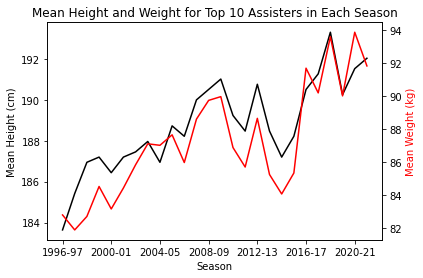

In [ ]:
top_10_players = nba.sort_values(by='ast_pct', ascending=False).groupby('season').head(10)
fig, ax1 = plt.subplots()

# Plot the mean height for top 10 scorers on the first y-axis
mean_height = top_10_players.groupby('season')['player_height'].mean()
ax1.plot(mean_height, color='black', label='Mean Height')
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Height (cm)', color='black')

# Create a second y-axis on the same plot
ax2 = ax1.twinx()

# Plot the mean weight for top 10 scorers on the second y-axis
mean_weight = top_10_players.groupby('season')['player_weight'].mean()
ax2.plot(mean_weight, color='r', label='Mean Weight')
ax2.set_ylabel('Mean Weight (kg)', color='r')

# Add a title and a legend to the plot
x_ticks = mean_height.index[::4]
plt.xticks(x_ticks, mean_height.index[::4])
plt.title('Mean Height and Weight for Top 10 Assisters in Each Season')

# Show the plot
plt.show()

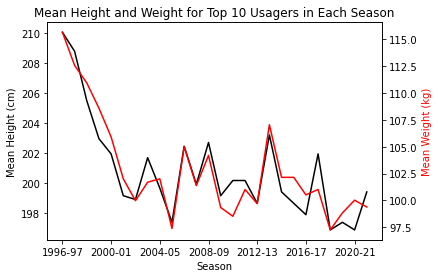

In [ ]:
top_10_players = nba.sort_values(by='usg_pct', ascending=False).groupby('season').head(10)
fig, ax1 = plt.subplots()

# Plot the mean height for top 10 scorers on the first y-axis
mean_height = top_10_players.groupby('season')['player_height'].mean()
ax1.plot(mean_height, color='black', label='Mean Height')
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Height (cm)', color='black')

# Create a second y-axis on the same plot
ax2 = ax1.twinx()

# Plot the mean weight for top 10 scorers on the second y-axis
mean_weight = top_10_players.groupby('season')['player_weight'].mean()
ax2.plot(mean_weight, color='r', label='Mean Weight')
ax2.set_ylabel('Mean Weight (kg)', color='r')

# Add a title and a legend to the plot
x_ticks = mean_height.index[::4]
plt.xticks(x_ticks, mean_height.index[::4])
plt.title('Mean Height and Weight for Top 10 Usagers in Each Season')

# Show the plot
plt.show()

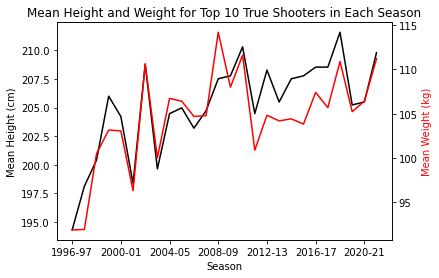

In [ ]:
top_10_players = nba.sort_values(by='ts_pct', ascending=False).groupby('season').head(10)
fig, ax1 = plt.subplots()

# Plot the mean height for top 10 scorers on the first y-axis
mean_height = top_10_players.groupby('season')['player_height'].mean()
ax1.plot(mean_height, color='black', label='Mean Height')
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Height (cm)', color='black')

# Create a second y-axis on the same plot
ax2 = ax1.twinx()

# Plot the mean weight for top 10 scorers on the second y-axis
mean_weight = top_10_players.groupby('season')['player_weight'].mean()
ax2.plot(mean_weight, color='r', label='Mean Weight')
ax2.set_ylabel('Mean Weight (kg)', color='r')

# Add a title and a legend to the plot
x_ticks = mean_height.index[::4]
plt.xticks(x_ticks, mean_height.index[::4])
plt.title('Mean Height and Weight for Top 10 True Shooters in Each Season')

# Show the plot
plt.show()

We wanted to make histograms to see the density of height and weight throughout certain period (we took 1996 season, 2010 season and 2021 season). We were curious to see how weights and heights were distributed, and clearly we see a lot of changes in these years, that coincide with trends in the league.

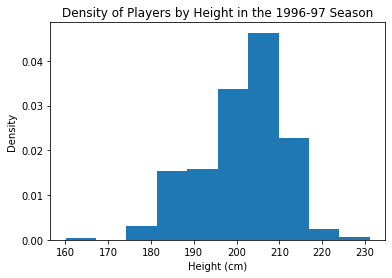

In [ ]:
nba_1996 = nba[nba['season'] == '1996-97']

# Set the number of bins
bins = 10

# Plot histogram with density
plt.hist(nba_1996['player_height'], bins=bins, density=True)

# Add labels
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.title('Density of Players by Height in the 1996-97 Season')

plt.show()

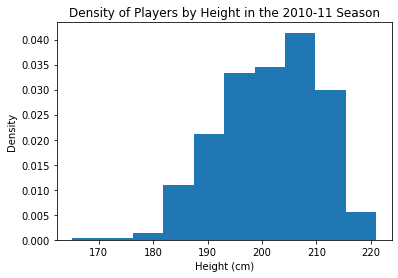

In [ ]:
nba_2010 = nba[nba['season'] == '2010-11']
# Set the number of bins
bins = 10

# Plot histogram with density
plt.hist(nba_2010['player_height'], bins=bins, density=True)

# Add labels
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.title('Density of Players by Height in the 2010-11 Season')

plt.show()

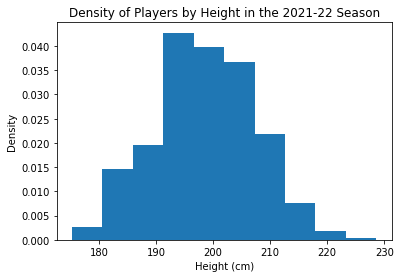

In [ ]:
nba_2021 = nba[nba['season'] == '2021-22']

# Set the number of bins
bins = 10

# Plot histogram with density
plt.hist(nba_2021['player_height'], bins=bins, density=True)

# Add labels
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.title('Density of Players by Height in the 2021-22 Season')

plt.show()

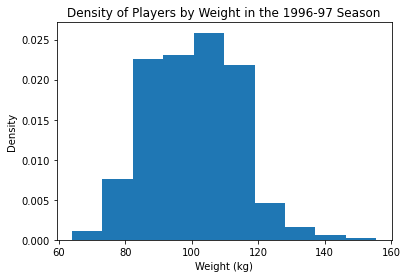

In [ ]:
nba_1996 = nba[nba['season'] == '1996-97']

# Set the number of bins
bins = 10

# Plot histogram with density
plt.hist(nba_1996['player_weight'], bins=bins, density=True)

# Add labels
plt.xlabel('Weight (kg)')
plt.ylabel('Density')
plt.title('Density of Players by Weight in the 1996-97 Season')

plt.show()

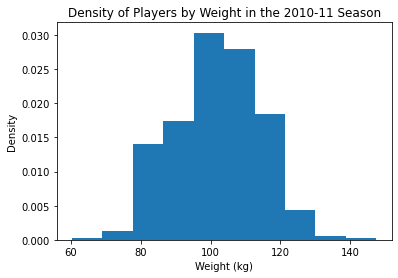

In [ ]:
nba_2010 = nba[nba['season'] == '2010-11']
# Set the number of bins
bins = 10

# Plot histogram with density
plt.hist(nba_2010['player_weight'], bins=bins, density=True)

# Add labels
plt.xlabel('Weight (kg)')
plt.ylabel('Density')
plt.title('Density of Players by Weight in the 2010-11 Season')

plt.show()

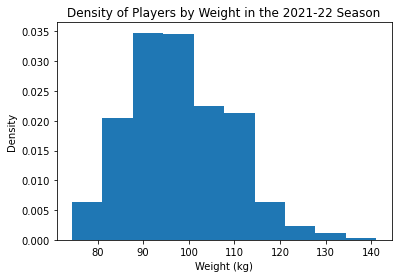

In [ ]:
nba_2021 = nba[nba['season'] == '2021-22']

# Set the number of bins
bins = 10

# Plot histogram with density
plt.hist(nba_2021['player_weight'], bins=bins, density=True)

# Add labels
plt.xlabel('Weight (kg)')
plt.ylabel('Density')
plt.title('Density of Players by Weight in the 2021-22 Season')

plt.show()

And at the end, we wanted to see how mean height of 10 tallest players in each season changed during the years.

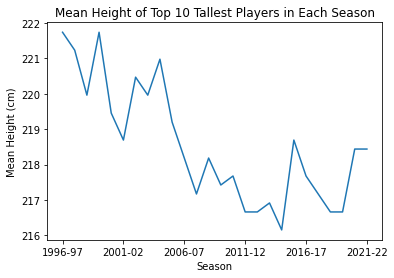

In [ ]:
top_10_tallest = nba.sort_values(by='player_height', ascending=False).groupby('season').head(10)
mean_height = top_10_tallest.groupby('season')['player_height'].mean()
mean_height.plot()
plt.xlabel('Season')
plt.ylabel('Mean Height (cm)')
plt.title('Mean Height of Top 10 Tallest Players in Each Season')
plt.show()

#### Conclusion:
If we analyze the average height and weight of the top 10 scorers in each season, we see that there have been large fluctuations in most years, from an average height of 204 cm around 2003 to 196 cm in 2019 (with weight strongly correlated with height). It's a bit difficult to predict how the top scorers will change throughout a season, and most dominant players change every year (e.g., due to injuries, age, team changes, or the number of possessions).
As the ball moves around more in the game, tall players need to be involved in the game, and we wanted to see how the average height and weight of the top 10 assists changed each season. The results are quite interesting, as the average height increased by about 8 cm and the average weight increased by almost 12 kg. For basketball fans, these results are to be expected as there is a new wave of tall players who are excellent playmakers and give more assists on average than guards.
The usage rate indicates the percentage of actions the player finished while he was on the court. The analysis shows that the average height and weight of 10 players have changed significantly in each season, with height decreasing by 10 cm and weight decreasing by almost 15 kg. This is closely related to the analysis of the assistants - in previous seasons tall players were the main finishers and guards only had the task of being playmakers, and now things have changed drastically.
ications for the future of the game and player recruitment and development.


## How well is it possible to predict the winner of the NBA match based on the attributes and statistics of the players playing in it?

In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
import glob

import warnings
warnings.filterwarnings('ignore')

import random as rn
rn.seed(40)  

In [9]:
# Get data file names
path_detailed = data_folder.joinpath('detailed')
# path_detailed = "C:/Users/Dusan/Desktop/Data-oriented Programming Paradigms/Exercise 02/data/detailed"
filenames = glob.glob(str(path_detailed) + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
df_detailed = pd.concat(dfs, ignore_index=True)
display(df_detailed)

date                 team                  player  \
0       1984-10-26T00:00:00  Cleveland Cavaliers           Campy Russell   
1       1984-10-26T00:00:00  Seattle SuperSonics                 Al Wood   
2       1984-10-26T00:00:00  Seattle SuperSonics            Tom Chambers   
3       1984-10-26T00:00:00  Seattle SuperSonics          Scooter McCray   
4       1984-10-26T00:00:00  Seattle SuperSonics            Jon Sundvold   
...                     ...                  ...                     ...   
894830  2021-07-01T20:30:00      Milwaukee Bucks             Jeff Teague   
894831  2021-07-01T20:30:00      Milwaukee Bucks           Elijah Bryant   
894832  2021-07-01T20:30:00      Milwaukee Bucks  Thanasis Antetokounmpo   
894833  2021-07-01T20:30:00        Atlanta Hawks            Lou Williams   
894834  2021-07-01T20:30:00      Milwaukee Bucks            Bobby Portis   

           role         MP  FG  FGA  FG_PCT  FG3  FG3A  ...  ORB  DRB  TRB  \
0       Reserve   5.083333   0    1   0.000    0     1  ...    0    0    0   
1       Starter  28.466667   9   15   0.600    0     0  ...    4    3    7   
2       Starter  26.433333   5   14   0.357    0     1  ...    3    4    7   
3       Reserve  23.383333   1    2   0.500    0     0  ...    0    4    4   
4       Reserve  22.366667   3    9   0.333    0     0  ...    1    1    2   
...         ...        ...  ..  ...     ...  ...   ...  ...  ...  ...  ...   
894830  Reserve       3.05   0    1   0.000    0     0  ...    0    0    0   
894831  Reserve        0.0   0    0     NaN    0     0  ...    0    0    0   
894832  Reserve       3.05   0    0     NaN    0     0  ...    0    0    0   
894833  Starter  35.583333   8   15   0.533    1     4  ...    0    2    2   
894834  Starter  35.583333   9   20   0.450    1     3  ...    3    5    8   

        AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  
0         0    0    0    0   0    0         NaN  
1         3    2    0    4   4   21         NaN  
2         6    1    0    4   5   11         NaN  
3         0    0    2    2   3    2         NaN  
4         2    0    0    1   5   12         NaN  
...     ...  ...  ...  ...  ..  ...         ...  
894830    3    0    0    1   0    0         0.0  
894831    0    0    0    0   0    0        -2.0  
894832    0    1    0    0   3    0        -4.0  
894833    5    1    0    6   1   17       -15.0  
894834    3    3    0    0   2   22        14.0  

[894835 rows x 24 columns]

In [ ]:
# drop unnecessary columns
drop_column_list = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS']
df_detailed.drop(drop_column_list, axis=1, inplace=True)

In [ ]:
# check for the missing values
df_detailed.isnull().sum(axis = 0)

date      0
team      0
player    0
role      0
MP        0
FG        0
FGA       0
FG3       0
FG3A      0
FT        0
FTA       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

In [ ]:
print(df_detailed['role'].unique())

# coding column 'role'
df_detailed['role'] = np.where(df_detailed['role'] == 'Starter', 1, 0)
display(df_detailed)

['Reserve' 'Starter']


date                 team                  player  \
0       1984-10-26T00:00:00  Cleveland Cavaliers           Campy Russell   
1       1984-10-26T00:00:00  Seattle SuperSonics                 Al Wood   
2       1984-10-26T00:00:00  Seattle SuperSonics            Tom Chambers   
3       1984-10-26T00:00:00  Seattle SuperSonics          Scooter McCray   
4       1984-10-26T00:00:00  Seattle SuperSonics            Jon Sundvold   
...                     ...                  ...                     ...   
894830  2021-07-01T20:30:00      Milwaukee Bucks             Jeff Teague   
894831  2021-07-01T20:30:00      Milwaukee Bucks           Elijah Bryant   
894832  2021-07-01T20:30:00      Milwaukee Bucks  Thanasis Antetokounmpo   
894833  2021-07-01T20:30:00        Atlanta Hawks            Lou Williams   
894834  2021-07-01T20:30:00      Milwaukee Bucks            Bobby Portis   

        role         MP  FG  FGA  FG3  FG3A  FT  FTA  ORB  DRB  TRB  AST  STL  \
0          0   5.083333   0    1    0     1   0    0    0    0    0    0    0   
1          1  28.466667   9   15    0     0   3    4    4    3    7    3    2   
2          1  26.433333   5   14    0     1   1    1    3    4    7    6    1   
3          0  23.383333   1    2    0     0   0    0    0    4    4    0    0   
4          0  22.366667   3    9    0     0   6    6    1    1    2    2    0   
...      ...        ...  ..  ...  ...   ...  ..  ...  ...  ...  ...  ...  ...   
894830     0       3.05   0    1    0     0   0    0    0    0    0    3    0   
894831     0        0.0   0    0    0     0   0    0    0    0    0    0    0   
894832     0       3.05   0    0    0     0   0    0    0    0    0    0    1   
894833     1  35.583333   8   15    1     4   0    0    0    2    2    5    1   
894834     1  35.583333   9   20    1     3   3    6    3    5    8    3    3   

        BLK  TOV  PF  PTS  
0         0    0   0    0  
1         0    4   4   21  
2         0    4   5   11  
3         2    2   3    2  
4         0    1   5   12  
...     ...  ...  ..  ...  
894830    0    1   0    0  
894831    0    0   0    0  
894832    0    0   3    0  
894833    0    6   1   17  
894834    0    0   2   22  

[894835 rows x 20 columns]

In [ ]:
print(df_detailed.dtypes, '\n')

# convert 'MP' from object to float
# df_detailed['MP'] = df_detailed['MP'].astype(float) 
# PRODUCES ValueError: could not convert string to float: '12:30'

print(df_detailed['MP'].str.contains(':').value_counts())

date      object
team      object
player    object
role       int32
MP        object
FG         int64
FGA        int64
FG3        int64
FG3A       int64
FT         int64
FTA        int64
ORB        int64
DRB        int64
TRB        int64
AST        int64
STL        int64
BLK        int64
TOV        int64
PF         int64
PTS        int64
dtype: object 

True    25586
Name: MP, dtype: int64


In [ ]:
# check for rows which contains ':' in 'MP' column
from re import search
i = 10
for ind in df_detailed.index:
    if search(':', str(df_detailed['MP'][ind])):
        min_sec_str = str(df_detailed['MP'][ind])
        min_sec = min_sec_str.split(":")
        min_part = int(min_sec[0])
        sec_part = float(min_sec[1])
        min_sec_format = str(min_part + round(sec_part/60.0, 6))
        print(min_sec_str, " -> ", min_sec_format)
        i = i-1
        if (i==0):
            break
            
# change all rows for 'MP' column to be in the right format
for ind in df_detailed.index:
    if search(':', str(df_detailed['MP'][ind])):
        min_sec_str = str(df_detailed['MP'][ind])
        min_sec = min_sec_str.split(":")
        min_part = int(min_sec[0])
        sec_part = float(min_sec[1])
        min_sec_format = str(min_part + round(sec_part/60.0, 6))
        
        df_detailed['MP'][ind] = min_sec_format


12:30  ->  12.5
6:13  ->  6.216667
13:41  ->  13.683333
13:42  ->  13.7
24:39  ->  24.65
28:48  ->  28.8
32:50  ->  32.833333
35:02  ->  35.033333
40:10  ->  40.166667
44:55  ->  44.916667


In [ ]:
# convert 'MP' from object to float
df_detailed['MP'] = df_detailed['MP'].astype(float) 

print(df_detailed.dtypes, '\n')

print(df_detailed.isna().sum())


date       object
team       object
player     object
role        int32
MP        float64
FG          int64
FGA         int64
FG3         int64
FG3A        int64
FT          int64
FTA         int64
ORB         int64
DRB         int64
TRB         int64
AST         int64
STL         int64
BLK         int64
TOV         int64
PF          int64
PTS         int64
dtype: object 

date      0
team      0
player    0
role      0
MP        0
FG        0
FGA       0
FG3       0
FG3A      0
FT        0
FTA       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64


In [ ]:
# final data from our dataset
display(df_detailed)

date                 team                  player  \
0       1984-10-26T00:00:00  Cleveland Cavaliers           Campy Russell   
1       1984-10-26T00:00:00  Seattle SuperSonics                 Al Wood   
2       1984-10-26T00:00:00  Seattle SuperSonics            Tom Chambers   
3       1984-10-26T00:00:00  Seattle SuperSonics          Scooter McCray   
4       1984-10-26T00:00:00  Seattle SuperSonics            Jon Sundvold   
...                     ...                  ...                     ...   
894830  2021-07-01T20:30:00      Milwaukee Bucks             Jeff Teague   
894831  2021-07-01T20:30:00      Milwaukee Bucks           Elijah Bryant   
894832  2021-07-01T20:30:00      Milwaukee Bucks  Thanasis Antetokounmpo   
894833  2021-07-01T20:30:00        Atlanta Hawks            Lou Williams   
894834  2021-07-01T20:30:00      Milwaukee Bucks            Bobby Portis   

        role         MP  FG  FGA  FG3  FG3A  FT  FTA  ORB  DRB  TRB  AST  STL  \
0          0   5.083333   0    1    0     1   0    0    0    0    0    0    0   
1          1  28.466667   9   15    0     0   3    4    4    3    7    3    2   
2          1  26.433333   5   14    0     1   1    1    3    4    7    6    1   
3          0  23.383333   1    2    0     0   0    0    0    4    4    0    0   
4          0  22.366667   3    9    0     0   6    6    1    1    2    2    0   
...      ...        ...  ..  ...  ...   ...  ..  ...  ...  ...  ...  ...  ...   
894830     0   3.050000   0    1    0     0   0    0    0    0    0    3    0   
894831     0   0.000000   0    0    0     0   0    0    0    0    0    0    0   
894832     0   3.050000   0    0    0     0   0    0    0    0    0    0    1   
894833     1  35.583333   8   15    1     4   0    0    0    2    2    5    1   
894834     1  35.583333   9   20    1     3   3    6    3    5    8    3    3   

        BLK  TOV  PF  PTS  
0         0    0   0    0  
1         0    4   4   21  
2         0    4   5   11  
3         2    2   3    2  
4         0    1   5   12  
...     ...  ...  ..  ...  
894830    0    1   0    0  
894831    0    0   0    0  
894832    0    0   3    0  
894833    0    6   1   17  
894834    0    0   2   22  

[894835 rows x 20 columns]

In [ ]:
df_detailed.sort_values(by=['player', 'date'], ascending=False, inplace=True, ignore_index=True)
display(df_detailed)

date                  team          player  role  \
0       2006-04-18T20:00:00  Los Angeles Clippers  Željko Rebrača     0   
1       2006-04-16T21:00:00  Los Angeles Clippers  Željko Rebrača     1   
2       2006-04-14T22:30:00  Los Angeles Clippers  Željko Rebrača     0   
3       2006-04-12T22:30:00  Los Angeles Clippers  Željko Rebrača     0   
4       2006-04-10T22:30:00  Los Angeles Clippers  Željko Rebrača     0   
...                     ...                   ...             ...   ...   
894830  1985-11-05T00:00:00    Los Angeles Lakers      A.C. Green     0   
894831  1985-11-02T00:00:00    Los Angeles Lakers      A.C. Green     0   
894832  1985-10-31T00:00:00    Los Angeles Lakers      A.C. Green     0   
894833  1985-10-29T00:00:00    Los Angeles Lakers      A.C. Green     0   
894834  1985-10-26T00:00:00    Los Angeles Lakers      A.C. Green     0   

               MP  FG  FGA  FG3  FG3A  FT  FTA  ORB  DRB  TRB  AST  STL  BLK  \
0       23.383333   2    5    0     0   4    4    0    2    2    0    0    1   
1       23.383333   2    5    0     0   3    4    1    2    3    0    0    0   
2       15.250000   1    3    0     0   2    2    0    2    2    0    0    1   
3        4.066667   1    2    0     0   0    0    0    1    1    0    0    0   
4       18.300000   1    2    0     0   2    2    0    0    0    0    0    3   
...           ...  ..  ...  ...   ...  ..  ...  ...  ...  ...  ...  ...  ...   
894830  23.383333   3    6    0     1   0    0    1    2    3    1    0    1   
894831  22.366667   2    3    0     0   4    4    1    1    2    0    1    1   
894832  25.416667   5    8    0     0   4    4    3    1    4    5    2    0   
894833  28.466667   8   10    0     0   1    2    6   10   16    4    0    0   
894834  19.316667   1    3    0     0   1    2    2    1    3    0    0    0   

        TOV  PF  PTS  
0         2   4    8  
1         1   1    7  
2         0   2    4  
3         0   3    2  
4         2   1    4  
...     ...  ..  ...  
894830    1   2    6  
894831    0   3    8  
894832    3   3   14  
894833    1   4   17  
894834    1   1    3  

[894835 rows x 20 columns]

In [ ]:
# saving the procesed player stats dataframe
df_detailed.to_csv('data_detailed_processed.csv')

In [ ]:
# get column names
column_names = list(df_detailed.columns)
# print(column_names)
column_names = [e for e in column_names if e not in ('date', 'team', 'player')]
print(column_names)

['role', 'MP', 'FG', 'FGA', 'FG3', 'FG3A', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [ ]:
# calculate the average stats for each player based on the last 10 games
df_avg = df_detailed.copy()
df = df_detailed # just for the simplicity

iteration = 0
for index_1, row in df.iterrows():
    
    current_player = row['player']
    num_games = 0
    sum_stats = np.zeros(len(column_names))
    index_2 = index_1 + 1
    
    
    while ((num_games < 10) and (index_2 < len(df.index)) and (df.loc[index_2, 'player'] == current_player)):
        
        new_row = df.loc[index_2]
        for i in range(0,len(column_names)):
            sum_stats[i] += new_row[column_names[i]]
            
        num_games += 1   
        index_2 += 1
            
    if num_games != 0:
        avg_stats = sum_stats / num_games
    else:
        avg_stats = sum_stats
        
    for ind_col in range(len(column_names)):
        df_avg.loc[index_1, column_names[ind_col]] = avg_stats[ind_col]
    
    iteration += 1
    if (iteration % 50000 == 0):
        print(iteration)
        
display(df_avg)

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000


date                  team          player  role  \
0       2006-04-18T20:00:00  Los Angeles Clippers  Željko Rebrača   0.1   
1       2006-04-16T21:00:00  Los Angeles Clippers  Željko Rebrača   0.1   
2       2006-04-14T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
3       2006-04-12T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
4       2006-04-10T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
...                     ...                   ...             ...   ...   
894830  1985-11-05T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894831  1985-11-02T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894832  1985-10-31T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894833  1985-10-29T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894834  1985-10-26T00:00:00    Los Angeles Lakers      A.C. Green   0.0   

               MP        FG  FGA  FG3  FG3A   FT       FTA       ORB   DRB  \
0       14.335000  1.700000  2.9  0.0   0.0  1.5  1.900000  0.400000  1.80   
1       13.928333  1.800000  3.1  0.0   0.0  1.3  1.700000  0.500000  1.70   
2       14.030000  2.200000  3.5  0.0   0.0  1.1  1.500000  0.500000  1.60   
3       15.148333  2.300000  3.7  0.0   0.0  1.1  1.700000  0.600000  1.90   
4       15.046667  2.300000  3.7  0.0   0.0  0.9  1.500000  0.700000  2.00   
...           ...       ...  ...  ...   ...  ...       ...       ...   ...   
894830  23.891667  4.000000  6.0  0.0   0.0  2.5  3.000000  3.000000  3.25   
894831  24.400000  4.666667  7.0  0.0   0.0  2.0  2.666667  3.666667  4.00   
894832  23.891667  4.500000  6.5  0.0   0.0  1.0  2.000000  4.000000  5.50   
894833  19.316667  1.000000  3.0  0.0   0.0  1.0  2.000000  2.000000  1.00   
894834   0.000000  0.000000  0.0  0.0   0.0  0.0  0.000000  0.000000  0.00   

             TRB   AST       STL   BLK       TOV        PF        PTS  
0       2.200000  0.20  0.000000  0.90  1.000000  2.000000   4.900000  
1       2.200000  0.30  0.000000  1.00  1.000000  2.000000   4.900000  
2       2.100000  0.30  0.000000  1.00  1.300000  2.100000   5.500000  
3       2.500000  0.30  0.000000  1.00  1.300000  2.200000   5.700000  
4       2.700000  0.40  0.000000  0.90  1.200000  2.300000   5.500000  
...          ...   ...       ...   ...       ...       ...        ...  
894830  6.250000  2.25  0.750000  0.25  1.250000  2.750000  10.500000  
894831  7.666667  3.00  0.666667  0.00  1.666667  2.666667  11.333333  
894832  9.500000  2.00  0.000000  0.00  1.000000  2.500000  10.000000  
894833  3.000000  0.00  0.000000  0.00  1.000000  1.000000   3.000000  
894834  0.000000  0.00  0.000000  0.00  0.000000  0.000000   0.000000  

[894835 rows x 20 columns]

In [ ]:
# saving the procesed player stats dataframe
df_avg.to_csv('data_detailed_processed_avg_10.csv')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
import glob

import warnings
warnings.filterwarnings('ignore')

import random as rn
rn.seed(40)  

In [11]:
# Load df with players' avg stats from the last 10 games
path_players_avg = "data_detailed_processed_avg_10.csv"
df_avg = pd.read_csv(path_players_avg, index_col=0)

display(df_avg)

date                  team          player  role  \
0       2006-04-18T20:00:00  Los Angeles Clippers  Željko Rebrača   0.1   
1       2006-04-16T21:00:00  Los Angeles Clippers  Željko Rebrača   0.1   
2       2006-04-14T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
3       2006-04-12T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
4       2006-04-10T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
...                     ...                   ...             ...   ...   
894830  1985-11-05T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894831  1985-11-02T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894832  1985-10-31T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894833  1985-10-29T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894834  1985-10-26T00:00:00    Los Angeles Lakers      A.C. Green   0.0   

               MP        FG  FGA  FG3  FG3A   FT       FTA       ORB   DRB  \
0       14.335000  1.700000  2.9  0.0   0.0  1.5  1.900000  0.400000  1.80   
1       13.928333  1.800000  3.1  0.0   0.0  1.3  1.700000  0.500000  1.70   
2       14.030000  2.200000  3.5  0.0   0.0  1.1  1.500000  0.500000  1.60   
3       15.148333  2.300000  3.7  0.0   0.0  1.1  1.700000  0.600000  1.90   
4       15.046667  2.300000  3.7  0.0   0.0  0.9  1.500000  0.700000  2.00   
...           ...       ...  ...  ...   ...  ...       ...       ...   ...   
894830  23.891667  4.000000  6.0  0.0   0.0  2.5  3.000000  3.000000  3.25   
894831  24.400000  4.666667  7.0  0.0   0.0  2.0  2.666667  3.666667  4.00   
894832  23.891667  4.500000  6.5  0.0   0.0  1.0  2.000000  4.000000  5.50   
894833  19.316667  1.000000  3.0  0.0   0.0  1.0  2.000000  2.000000  1.00   
894834   0.000000  0.000000  0.0  0.0   0.0  0.0  0.000000  0.000000  0.00   

             TRB   AST       STL   BLK       TOV        PF        PTS  
0       2.200000  0.20  0.000000  0.90  1.000000  2.000000   4.900000  
1       2.200000  0.30  0.000000  1.00  1.000000  2.000000   4.900000  
2       2.100000  0.30  0.000000  1.00  1.300000  2.100000   5.500000  
3       2.500000  0.30  0.000000  1.00  1.300000  2.200000   5.700000  
4       2.700000  0.40  0.000000  0.90  1.200000  2.300000   5.500000  
...          ...   ...       ...   ...       ...       ...        ...  
894830  6.250000  2.25  0.750000  0.25  1.250000  2.750000  10.500000  
894831  7.666667  3.00  0.666667  0.00  1.666667  2.666667  11.333333  
894832  9.500000  2.00  0.000000  0.00  1.000000  2.500000  10.000000  
894833  3.000000  0.00  0.000000  0.00  1.000000  1.000000   3.000000  
894834  0.000000  0.00  0.000000  0.00  0.000000  0.000000   0.000000  

[894835 rows x 20 columns]

In [ ]:
# get statistics from every column
df_avg.describe()

role             MP             FG            FGA  \
count  894835.000000  894835.000000  894835.000000  894835.000000   
mean        0.486814      23.587015       3.735729       8.124530   
std         0.452697      10.195143       2.402416       4.923023   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000      15.453333       1.800000       4.200000   
50%         0.400000      23.993333       3.300000       7.200000   
75%         1.000000      32.228333       5.200000      11.300000   
max         1.000000      51.850000      19.000000      32.700000   

                 FG3           FG3A             FT            FTA  \
count  894835.000000  894835.000000  894835.000000  894835.000000   
mean        0.561397       1.588612       1.872982       2.479779   
std         0.746565       1.898509       1.634427       2.047288   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.700000       1.000000   
50%         0.200000       0.800000       1.400000       1.900000   
75%         0.900000       2.700000       2.600000       3.400000   
max         7.200000      17.000000      14.200000      17.500000   

                 ORB            DRB            TRB            AST  \
count  894835.000000  894835.000000  894835.000000  894835.000000   
mean        1.176291       2.975005       4.151296       2.221888   
std         0.987545       1.980329       2.769782       2.091226   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.400000       1.500000       2.100000       0.750000   
50%         0.900000       2.500000       3.500000       1.600000   
75%         1.700000       4.000000       5.500000       3.000000   
max         9.000000      17.000000      23.600000      17.900000   

                 STL            BLK            TOV             PF  \
count  894835.000000  894835.000000  894835.000000  894835.000000   
mean        0.772487       0.490056       1.417809       2.136988   
std         0.557029       0.598116       0.907217       0.896681   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.400000       0.100000       0.700000       1.500000   
50%         0.700000       0.300000       1.200000       2.100000   
75%         1.100000       0.600000       1.900000       2.800000   
max         9.000000       8.000000      11.000000       6.000000   

                 PTS  
count  894835.000000  
mean        9.905837  
std         6.454241  
min         0.000000  
25%         4.800000  
50%         8.700000  
75%        13.900000  
max        47.000000

In [ ]:
# Load df with players' stats
path_players = "data_detailed_processed.csv"
df_detailed = pd.read_csv(path_players, index_col=0)

In [ ]:
# separate starters and bench players
df_starters = df_avg[df_detailed['role'] == 1]
df_bench = df_avg[df_detailed['role'] == 0]

display(df_starters)
display(df_bench)

date                  team          player  role  \
1       2006-04-16T21:00:00  Los Angeles Clippers  Željko Rebrača   0.1   
11      2006-03-01T22:30:00  Los Angeles Clippers  Željko Rebrača   0.0   
30      2005-04-16T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
32      2005-04-01T20:00:00  Los Angeles Clippers  Željko Rebrača   0.0   
90      2004-02-11T19:30:00       Detroit Pistons  Željko Rebrača   0.0   
...                     ...                   ...             ...   ...   
894738  1986-11-30T00:00:00    Los Angeles Lakers      A.C. Green   0.3   
894739  1986-11-28T00:00:00    Los Angeles Lakers      A.C. Green   0.2   
894740  1986-11-26T00:00:00    Los Angeles Lakers      A.C. Green   0.1   
894741  1986-11-25T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894754  1986-04-12T00:00:00    Los Angeles Lakers      A.C. Green   0.0   

               MP   FG  FGA  FG3  FG3A   FT  FTA  ORB  DRB  TRB  AST  STL  \
1       13.928333  1.8  3.1  0.0   0.0  1.3  1.7  0.5  1.7  2.2  0.3  0.0   
11      11.285000  1.7  2.9  0.0   0.0  0.4  0.6  0.5  1.3  1.8  0.4  0.3   
30      16.876667  3.1  5.5  0.0   0.0  1.3  1.6  0.7  2.1  2.8  0.4  0.1   
32      18.808333  3.5  6.1  0.0   0.0  1.5  1.9  0.8  2.6  3.4  0.6  0.2   
90      10.268333  0.7  1.9  0.0   0.0  0.9  1.1  0.8  1.5  2.3  0.3  0.2   
...           ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...  ...   
894738  19.011667  3.0  5.2  0.0   0.1  1.9  2.4  1.1  3.3  4.4  0.6  1.3   
894739  15.250000  2.6  4.6  0.0   0.1  1.2  1.6  0.8  2.4  3.2  0.6  1.1   
894740  12.606667  1.8  3.7  0.0   0.1  1.0  1.2  0.7  1.8  2.5  0.5  0.7   
894741  11.488333  1.2  2.8  0.0   0.0  0.4  0.6  0.7  1.5  2.2  0.5  0.6   
894754  11.691667  1.0  1.7  0.0   0.1  0.7  1.1  0.9  1.6  2.5  0.0  0.5   

        BLK  TOV   PF  PTS  
1       1.0  1.0  2.0  4.9  
11      0.4  0.8  2.2  3.8  
30      0.6  1.2  2.3  7.5  
32      0.6  1.3  2.4  8.5  
90      0.6  0.4  2.3  2.3  
...     ...  ...  ...  ...  
894738  1.0  1.3  1.6  7.9  
894739  0.8  1.0  1.1  6.4  
894740  0.5  0.9  1.0  4.6  
894741  0.4  0.6  0.8  2.8  
894754  0.2  0.7  2.2  2.7  

[436490 rows x 20 columns]

date                  team          player  role  \
0       2006-04-18T20:00:00  Los Angeles Clippers  Željko Rebrača   0.1   
2       2006-04-14T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
3       2006-04-12T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
4       2006-04-10T22:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
5       2006-04-09T21:30:00  Los Angeles Clippers  Željko Rebrača   0.1   
...                     ...                   ...             ...   ...   
894830  1985-11-05T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894831  1985-11-02T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894832  1985-10-31T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894833  1985-10-29T00:00:00    Los Angeles Lakers      A.C. Green   0.0   
894834  1985-10-26T00:00:00    Los Angeles Lakers      A.C. Green   0.0   

               MP        FG  FGA  FG3  FG3A   FT       FTA       ORB   DRB  \
0       14.335000  1.700000  2.9  0.0   0.0  1.5  1.900000  0.400000  1.80   
2       14.030000  2.200000  3.5  0.0   0.0  1.1  1.500000  0.500000  1.60   
3       15.148333  2.300000  3.7  0.0   0.0  1.1  1.700000  0.600000  1.90   
4       15.046667  2.300000  3.7  0.0   0.0  0.9  1.500000  0.700000  2.00   
5       14.945000  2.100000  3.5  0.0   0.0  1.0  1.500000  0.800000  2.00   
...           ...       ...  ...  ...   ...  ...       ...       ...   ...   
894830  23.891667  4.000000  6.0  0.0   0.0  2.5  3.000000  3.000000  3.25   
894831  24.400000  4.666667  7.0  0.0   0.0  2.0  2.666667  3.666667  4.00   
894832  23.891667  4.500000  6.5  0.0   0.0  1.0  2.000000  4.000000  5.50   
894833  19.316667  1.000000  3.0  0.0   0.0  1.0  2.000000  2.000000  1.00   
894834   0.000000  0.000000  0.0  0.0   0.0  0.0  0.000000  0.000000  0.00   

             TRB   AST       STL   BLK       TOV        PF        PTS  
0       2.200000  0.20  0.000000  0.90  1.000000  2.000000   4.900000  
2       2.100000  0.30  0.000000  1.00  1.300000  2.100000   5.500000  
3       2.500000  0.30  0.000000  1.00  1.300000  2.200000   5.700000  
4       2.700000  0.40  0.000000  0.90  1.200000  2.300000   5.500000  
5       2.800000  0.40  0.000000  0.90  1.100000  2.400000   5.200000  
...          ...   ...       ...   ...       ...       ...        ...  
894830  6.250000  2.25  0.750000  0.25  1.250000  2.750000  10.500000  
894831  7.666667  3.00  0.666667  0.00  1.666667  2.666667  11.333333  
894832  9.500000  2.00  0.000000  0.00  1.000000  2.500000  10.000000  
894833  3.000000  0.00  0.000000  0.00  1.000000  1.000000   3.000000  
894834  0.000000  0.00  0.000000  0.00  0.000000  0.000000   0.000000  

[458345 rows x 20 columns]

In [ ]:
# drop "player" column, since we don't need it for stats
df_bench_noname = df_bench.drop('player', axis=1)

# group by "date" and "team" and calculate sum of all stats
df_bench_sum = df_bench_noname.groupby(['date','team'], as_index=False).sum()
display(df_bench_sum)

date                  team      role          MP  \
0      1984-10-26T00:00:00         Atlanta Hawks  0.000000    0.000000   
1      1984-10-26T00:00:00        Boston Celtics  0.000000    0.000000   
2      1984-10-26T00:00:00         Chicago Bulls  0.000000    0.000000   
3      1984-10-26T00:00:00   Cleveland Cavaliers  0.000000    0.000000   
4      1984-10-26T00:00:00       Detroit Pistons  0.000000    0.000000   
...                    ...                   ...       ...         ...   
87293  2021-06-29T20:30:00       Milwaukee Bucks  0.400000   93.623704   
87294  2021-06-30T21:00:00  Los Angeles Clippers  0.611111   75.391481   
87295  2021-06-30T21:00:00          Phoenix Suns  0.400000   84.180000   
87296  2021-07-01T20:30:00         Atlanta Hawks  1.400000  106.343333   
87297  2021-07-01T20:30:00       Milwaukee Bucks  0.100000   54.493333   

              FG        FGA       FG3       FG3A        FT        FTA  \
0       0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
1       0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
2       0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
3       0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
4       0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
...          ...        ...       ...        ...       ...        ...   
87293  13.333333  32.244444  4.911111  15.044444  4.733333   6.033333   
87294  10.655556  24.300000  3.822222  10.600000  2.855556   3.355556   
87295  14.100000  31.300000  4.300000  11.300000  4.800000   5.900000   
87296  14.800000  33.800000  4.000000  13.000000  8.500000  10.400000   
87297   6.100000  15.600000  2.800000   9.000000  3.100000   3.500000   

            ORB        DRB        TRB       AST       STL       BLK       TOV  \
0      0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...        ...        ...       ...       ...       ...       ...   
87293  4.844444  13.355556  18.200000  4.777778  3.622222  2.222222  4.266667   
87294  3.422222  11.144444  14.566667  4.511111  3.344444  1.600000  2.377778   
87295  3.300000  13.300000  16.600000  8.500000  1.700000  2.300000  3.900000   
87296  3.200000  15.600000  18.800000  5.300000  3.500000  2.700000  3.600000   
87297  2.100000   6.000000   8.100000  3.400000  1.300000  1.200000  2.400000   

              PF        PTS  
0       0.000000   0.000000  
1       0.000000   0.000000  
2       0.000000   0.000000  
3       0.000000   0.000000  
4       0.000000   0.000000  
...          ...        ...  
87293   7.455556  36.311111  
87294   6.855556  27.988889  
87295   7.900000  37.300000  
87296  11.100000  42.100000  
87297   3.700000  18.100000  

[87298 rows x 19 columns]

In [ ]:
# drop "player" column, since we don't need it for stats
df_starters_noname = df_starters.drop('player', axis=1)
df_starters_noname["starters"] = True
df_bench_sum["starters"] = False

# concatenating df_starters_noname and df_bench_sum along rows
df_player_stats = pd.concat([df_starters_noname, df_bench_sum], axis=0, ignore_index=True)

df_player_stats.sort_values(by=['team', 'date'], ascending=False, inplace=True, ignore_index=True)

display(df_player_stats)
df_player_stats.head(20)

date                team  role         MP    FG   FGA  \
0       2021-06-02T19:00:00  Washington Wizards   1.0  38.023333   6.8  17.8   
1       2021-06-02T19:00:00  Washington Wizards   1.0  29.991667   5.9  10.4   
2       2021-06-02T19:00:00  Washington Wizards   0.8  24.908333   3.2   7.4   
3       2021-06-02T19:00:00  Washington Wizards   0.1  20.028333   4.6   6.1   
4       2021-06-02T19:00:00  Washington Wizards   1.0  37.718333  11.7  24.6   
...                     ...                 ...   ...        ...   ...   ...   
523783  1984-10-26T00:00:00       Atlanta Hawks   0.0   0.000000   0.0   0.0   
523784  1984-10-26T00:00:00       Atlanta Hawks   0.0   0.000000   0.0   0.0   
523785  1984-10-26T00:00:00       Atlanta Hawks   0.0   0.000000   0.0   0.0   
523786  1984-10-26T00:00:00       Atlanta Hawks   0.0   0.000000   0.0   0.0   
523787  1984-10-26T00:00:00       Atlanta Hawks   0.0   0.000000   0.0   0.0   

        FG3  FG3A   FT  FTA  ORB  DRB   TRB   AST  STL  BLK  TOV   PF   PTS  \
0       1.3   4.9  6.6  8.3  2.2  8.9  11.1  13.2  1.3  0.3  3.5  3.3  21.5   
1       1.4   2.5  0.8  1.3  0.8  4.6   5.4   0.9  0.4  0.2  0.9  2.8  14.0   
2       0.9   2.9  1.8  1.9  0.5  2.0   2.5   1.3  0.8  0.1  0.9  2.3   9.1   
3       0.0   0.0  2.6  3.4  2.5  3.4   5.9   0.6  0.6  2.0  0.9  2.5  11.8   
4       2.0   6.3  5.6  7.0  1.0  4.8   5.8   3.9  0.7  0.8  2.9  1.4  31.0   
...     ...   ...  ...  ...  ...  ...   ...   ...  ...  ...  ...  ...   ...   
523783  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   
523784  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   
523785  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   
523786  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   
523787  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   0.0   

        starters  
0           True  
1           True  
2           True  
3           True  
4           True  
...          ...  
523783      True  
523784      True  
523785      True  
523786      True  
523787     False  

[523788 rows x 20 columns]

date                team  role          MP    FG   FGA  \
0   2021-06-02T19:00:00  Washington Wizards   1.0   38.023333   6.8  17.8   
1   2021-06-02T19:00:00  Washington Wizards   1.0   29.991667   5.9  10.4   
2   2021-06-02T19:00:00  Washington Wizards   0.8   24.908333   3.2   7.4   
3   2021-06-02T19:00:00  Washington Wizards   0.1   20.028333   4.6   6.1   
4   2021-06-02T19:00:00  Washington Wizards   1.0   37.718333  11.7  24.6   
5   2021-06-02T19:00:00  Washington Wizards   1.5   89.568333  15.0  31.1   
6   2021-05-31T19:00:00  Washington Wizards   1.0   38.125000   7.6  18.5   
7   2021-05-31T19:00:00  Washington Wizards   1.0   29.280000   5.7  10.5   
8   2021-05-31T19:00:00  Washington Wizards   0.3   28.873333   3.2   8.6   
9   2021-05-31T19:00:00  Washington Wizards   0.0   19.011667   4.4   6.0   
10  2021-05-31T19:00:00  Washington Wizards   1.0   37.210000  11.9  24.7   
11  2021-05-31T19:00:00  Washington Wizards   2.2   95.160000  16.6  33.6   
12  2021-05-29T19:00:00  Washington Wizards   1.0   39.040000   7.2  18.6   
13  2021-05-29T19:00:00  Washington Wizards   1.0   29.686667   6.5  11.6   
14  2021-05-29T19:00:00  Washington Wizards   0.2   29.178333   3.3   8.8   
15  2021-05-29T19:00:00  Washington Wizards   1.0   37.108333  11.8  24.1   
16  2021-05-29T19:00:00  Washington Wizards   1.0   13.623333   2.3   4.4   
17  2021-05-29T19:00:00  Washington Wizards   1.6  112.748333  20.1  37.7   
18  2021-05-26T19:00:00  Washington Wizards   1.0   40.158333   8.2  19.6   
19  2021-05-26T19:00:00  Washington Wizards   1.0   29.991667   6.8  12.1   

    FG3  FG3A   FT  FTA  ORB   DRB   TRB   AST  STL  BLK  TOV    PF   PTS  \
0   1.3   4.9  6.6  8.3  2.2   8.9  11.1  13.2  1.3  0.3  3.5   3.3  21.5   
1   1.4   2.5  0.8  1.3  0.8   4.6   5.4   0.9  0.4  0.2  0.9   2.8  14.0   
2   0.9   2.9  1.8  1.9  0.5   2.0   2.5   1.3  0.8  0.1  0.9   2.3   9.1   
3   0.0   0.0  2.6  3.4  2.5   3.4   5.9   0.6  0.6  2.0  0.9   2.5  11.8   
4   2.0   6.3  5.6  7.0  1.0   4.8   5.8   3.9  0.7  0.8  2.9   1.4  31.0   
5   2.1   6.1  4.3  5.8  4.1  11.9  16.0   5.9  3.1  2.5  3.4   9.9  36.4   
6   1.6   5.2  6.1  7.6  2.0   8.9  10.9  13.3  1.2  0.5  3.8   3.2  22.9   
7   1.1   2.2  0.8  1.2  0.8   3.9   4.7   0.8  0.3  0.2  0.9   2.6  13.3   
8   2.4   7.5  1.4  1.7  0.0   2.0   2.0   0.3  0.6  0.1  0.6   2.4  10.2   
9   0.0   0.0  2.4  2.9  2.4   3.3   5.7   0.7  0.6  1.5  0.9   2.6  11.2   
10  1.9   6.3  5.2  6.7  1.2   4.7   5.9   4.1  0.8  0.7  2.7   1.3  30.9   
11  2.1   6.3  4.3  5.5  4.8  12.2  17.0   7.1  3.4  2.1  4.1  10.0  39.6   
12  1.4   5.2  5.8  7.5  1.8   9.6  11.4  14.0  1.3  0.5  4.2   3.4  21.6   
13  1.0   2.1  1.0  1.2  0.8   4.1   4.9   1.0  0.2  0.3  1.0   2.2  15.0   
14  2.6   7.8  1.6  1.9  0.0   2.5   2.5   0.3  0.5  0.1  0.5   2.7  10.8   
15  1.9   6.0  5.8  7.2  1.2   4.5   5.7   4.1  0.9  0.6  2.9   1.7  31.3   
16  0.0   0.0  1.1  1.5  1.7   3.5   5.2   0.6  0.6  0.8  0.5   2.0   5.7   
17  3.2   8.6  7.8  9.4  5.5  12.7  18.2   8.0  3.6  3.5  4.6  12.4  51.2   
18  1.4   5.1  5.7  7.3  1.6  10.4  12.0  14.6  1.6  0.6  4.0   3.7  23.5   
19  1.0   2.2  1.1  1.4  0.7   3.7   4.4   0.9  0.2  0.3  0.9   2.1  15.7   

    starters  
0       True  
1       True  
2       True  
3       True  
4       True  
5      False  
6       True  
7       True  
8       True  
9       True  
10      True  
11     False  
12      True  
13      True  
14      True  
15      True  
16      True  
17     False  
18      True  
19      True

In [ ]:
# get number of games
print(df_player_stats.groupby(['date', 'team']).ngroups / 2)
# this is equal of number of player stats / 6, so from every game every team has 6 players' stats!

# another check if every team in every game has exactly 6 rows
group_check = df_player_stats.groupby(['date', 'team'])
err = False
for name, group in group_check:
    if (len(group) != 6):
        err = True
if err == True:
    print("ERROR!!")
else:
    print("Everything is okay!")
        

43649.0
Everything is okay!


In [ ]:
# get column names
column_names = list(df_player_stats.columns)
# print(column_names)
column_names = [e for e in column_names if e not in ('date', 'team', 'starters')]
#print(column_names)

# make new column names
new_column_names = ['date', 'team']
for j in range(len(column_names)):
    for i in range(6):
        col_name = column_names[j] + "_" + str(i+1)
        new_column_names.append(col_name)
#print(new_column_names)
print(len(new_column_names))

104


In [ ]:
# the goal here is to get players' stats for every team on every game
# we will split the starters and sort them by avg points in the last 10 games (1-5)
# we wil make a sum of all players' stats for all bench players (6)

# define empty dataframe
df_stats_final = pd.DataFrame(columns=new_column_names)

# iterate through groups
df_player_stats_grouped = df_player_stats.groupby(['date', 'team'])

i = 0
for name, group in df_player_stats_grouped:
    
    group_starters = group[group['starters'] == True]
    group_bench = group[group['starters'] == False]
    
    group_starters.sort_values(by=['PTS'], ascending=False, inplace=True)
    group = pd.concat([group_starters, group_bench], axis=0)
    
    group.drop(['date','team','starters'], axis=1, inplace=True)
    #display(group)
    
    group_onerow = group.unstack().to_frame().T
    # display(group_onerow)
    group_onerow.columns = new_column_names[2:]
    
    group_onerow['date'] = name[0]
    group_onerow['team'] = name[1]
    
    # concatenating df_stats_final and one row
    df_stats_final = df_stats_final.append(group_onerow, ignore_index=True)
    
    i += 1 
    if (i % 10000 == 0):
        print(i)

display(df_stats_final)
        

10000
20000
30000
40000
50000
60000
70000
80000


date                  team  role_1  role_2  role_3  \
0      1984-10-26T00:00:00         Atlanta Hawks     0.0     0.0     0.0   
1      1984-10-26T00:00:00        Boston Celtics     0.0     0.0     0.0   
2      1984-10-26T00:00:00         Chicago Bulls     0.0     0.0     0.0   
3      1984-10-26T00:00:00   Cleveland Cavaliers     0.0     0.0     0.0   
4      1984-10-26T00:00:00       Detroit Pistons     0.0     0.0     0.0   
...                    ...                   ...     ...     ...     ...   
87293  2021-06-29T20:30:00       Milwaukee Bucks     1.0     1.0     1.0   
87294  2021-06-30T21:00:00  Los Angeles Clippers     1.0     1.0     0.9   
87295  2021-06-30T21:00:00          Phoenix Suns     1.0     1.0     1.0   
87296  2021-07-01T20:30:00         Atlanta Hawks     1.0     0.8     1.0   
87297  2021-07-01T20:30:00       Milwaukee Bucks     1.0     1.0     1.0   

       role_4  role_5    role_6       MP_1       MP_2  ...  PF_3  PF_4  PF_5  \
0         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
1         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
2         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
3         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
4         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
...       ...     ...       ...        ...        ...  ...   ...   ...   ...   
87293     1.0     1.0  0.400000  39.446667  40.870000  ...   2.4   1.4   3.6   
87294     0.5     0.4  0.611111  41.378333  35.888333  ...   1.9   2.8   2.7   
87295     1.0     1.0  0.400000  40.768333  33.753333  ...   2.0   2.1   2.6   
87296     1.0     0.1  1.400000  33.448333  34.668333  ...   2.5   2.9   1.3   
87297     0.0     1.0  0.100000  40.870000  39.751667  ...   1.6   1.4   3.5   

            PF_6  PTS_1  PTS_2  PTS_3  PTS_4  PTS_5      PTS_6  
0       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
1       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
2       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
3       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
4       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
...          ...    ...    ...    ...    ...    ...        ...  
87293   7.455556   31.5   23.8   16.7   11.3    4.4  36.311111  
87294   6.855556   30.5   20.8   11.7   10.7    5.4  27.988889  
87295   7.900000   27.9   19.2   15.6   11.7    9.7  37.300000  
87296  11.100000   13.6   12.4   11.2   10.0    7.8  42.100000  
87297   3.700000   24.1   16.9   10.1    7.7    4.5  18.100000  

[87298 rows x 104 columns]

In [ ]:
# get statistics from every column
df_stats_final.describe()

role_1        role_2        role_3        role_4        role_5  \
count  87298.000000  87298.000000  87298.000000  87298.000000  87298.000000   
mean       0.981299      0.946633      0.904294      0.835695      0.705724   
std        0.096039      0.169317      0.225119      0.292399      0.364471   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      1.000000      0.800000      0.400000   
50%        1.000000      1.000000      1.000000      1.000000      0.900000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             role_6          MP_1          MP_2          MP_3          MP_4  \
count  87298.000000  87298.000000  87298.000000  87298.000000  87298.000000   
mean       0.616373     36.631485     34.296799     31.759298     28.564556   
std        0.579267      3.673185      4.277312      4.885567      5.813829   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.100000     34.363333     31.720000     28.670000     25.010000   
50%        0.500000     36.905000     34.566667     32.126667     29.076667   
75%        1.000000     39.243333     37.311667     35.176667     32.635000   
max        4.800000     48.190000     47.376667     47.173333     46.766667   

       ...          PF_3          PF_4          PF_5          PF_6  \
count  ...  87298.000000  87298.000000  87298.000000  87298.000000   
mean   ...      2.571393      2.519503      2.395698      9.196899   
std    ...      0.755387      0.777693      0.835751      2.422450   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      2.000000      2.000000      1.800000      7.500000   
50%    ...      2.500000      2.500000      2.400000      9.000000   
75%    ...      3.100000      3.100000      3.000000     10.733333   
max    ...      6.000000      6.000000      6.000000     24.822222   

              PTS_1         PTS_2         PTS_3         PTS_4         PTS_5  \
count  87298.000000  87298.000000  87298.000000  87298.000000  87298.000000   
mean      22.029300     16.885339     13.299814     10.168609      6.760478   
std        4.569612      3.354305      2.892702      2.766167      2.789093   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       18.800000     14.600000     11.300000      8.300000      4.700000   
50%       21.600000     16.800000     13.300000     10.200000      6.600000   
75%       24.800000     19.000000     15.200000     12.000000      8.700000   
max       47.000000     33.500000     27.000000     22.500000     18.400000   

              PTS_6  
count  87298.000000  
mean      32.394746  
std        9.845742  
min        0.000000  
25%       25.500000  
50%       31.700000  
75%       38.500000  
max       91.300000  

[8 rows x 102 columns]

In [ ]:
# check for the missing values (just in case)
print(df_stats_final.isnull().sum(axis = 0))

# saving the final procesed player stats dataframe
df_stats_final.to_csv('df_stats_final.csv')

date      0
team      0
role_1    0
role_2    0
role_3    0
         ..
PTS_2     0
PTS_3     0
PTS_4     0
PTS_5     0
PTS_6     0
Length: 104, dtype: int64


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
import glob

import warnings
warnings.filterwarnings('ignore')

import random as rn
rn.seed(40)  

In [12]:
# Get data file names
path_basic = data_folder.joinpath('basic')
# path_basic = "C:/Users/Dusan/Desktop/Data-oriented Programming Paradigms/Exercise 02/data/basic"
filenames = glob.glob(str(path_basic) + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
df_basic = pd.concat(dfs, ignore_index=True)
display(df_basic)

date    weekday             home_team  home_score  \
0      1984-10-26T00:00:00     Friday    Philadelphia 76ers         111   
1      1984-10-26T00:00:00     Friday       Detroit Pistons         123   
2      1984-10-26T00:00:00     Friday         Chicago Bulls         109   
3      1984-10-26T00:00:00     Friday   Seattle SuperSonics         102   
4      1984-10-26T00:00:00     Friday       New Jersey Nets         104   
...                    ...        ...                   ...         ...   
43646  2021-06-27T20:30:00     Sunday         Atlanta Hawks         102   
43647  2021-06-28T21:00:00     Monday          Phoenix Suns         102   
43648  2021-06-29T20:30:00    Tuesday         Atlanta Hawks         110   
43649  2021-06-30T21:00:00  Wednesday  Los Angeles Clippers         103   
43650  2021-07-01T20:30:00   Thursday       Milwaukee Bucks         123   

                  away_team  away_score  attendance overtime remarks  
0       Cleveland Cavaliers         101     27563.0      NaN     NaN  
1            Boston Celtics         130     27563.0      NaN     NaN  
2        Washington Bullets          93     27563.0      NaN     NaN  
3                 Utah Jazz          94     27563.0      NaN     NaN  
4             Atlanta Hawks         119     27563.0      NaN     NaN  
...                     ...         ...         ...      ...     ...  
43646       Milwaukee Bucks         113     14993.0      NaN     NaN  
43647  Los Angeles Clippers         116     14993.0      NaN     NaN  
43648       Milwaukee Bucks          88     14993.0      NaN     NaN  
43649          Phoenix Suns         130     14993.0      NaN     NaN  
43650         Atlanta Hawks         112     16389.0      NaN     NaN  

[43651 rows x 9 columns]

In [ ]:
# create win/lose output for the model
df_basic['win'] = 0
df_basic.loc[df_basic['home_score'] > df_basic['away_score'], 'win'] = 1

display(df_basic)

date    weekday             home_team  home_score  \
0      1984-10-26T00:00:00     Friday    Philadelphia 76ers         111   
1      1984-10-26T00:00:00     Friday       Detroit Pistons         123   
2      1984-10-26T00:00:00     Friday         Chicago Bulls         109   
3      1984-10-26T00:00:00     Friday   Seattle SuperSonics         102   
4      1984-10-26T00:00:00     Friday       New Jersey Nets         104   
...                    ...        ...                   ...         ...   
43646  2021-06-27T20:30:00     Sunday         Atlanta Hawks         102   
43647  2021-06-28T21:00:00     Monday          Phoenix Suns         102   
43648  2021-06-29T20:30:00    Tuesday         Atlanta Hawks         110   
43649  2021-06-30T21:00:00  Wednesday  Los Angeles Clippers         103   
43650  2021-07-01T20:30:00   Thursday       Milwaukee Bucks         123   

                  away_team  away_score  attendance overtime remarks  win  
0       Cleveland Cavaliers         101     27563.0      NaN     NaN    1  
1            Boston Celtics         130     27563.0      NaN     NaN    0  
2        Washington Bullets          93     27563.0      NaN     NaN    1  
3                 Utah Jazz          94     27563.0      NaN     NaN    1  
4             Atlanta Hawks         119     27563.0      NaN     NaN    0  
...                     ...         ...         ...      ...     ...  ...  
43646       Milwaukee Bucks         113     14993.0      NaN     NaN    0  
43647  Los Angeles Clippers         116     14993.0      NaN     NaN    0  
43648       Milwaukee Bucks          88     14993.0      NaN     NaN    1  
43649          Phoenix Suns         130     14993.0      NaN     NaN    0  
43650         Atlanta Hawks         112     16389.0      NaN     NaN    1  

[43651 rows x 10 columns]

In [ ]:
# drop unnecessary columns
drop_column_list = ['weekday', 'attendance', 'overtime', 'remarks', 'home_score', 'away_score']
df_basic.drop(drop_column_list, axis=1, inplace=True)


In [ ]:
# check for the missing values
df_basic.isnull().sum(axis = 0)

date         0
home_team    0
away_team    0
win          0
dtype: int64

In [ ]:
# games data from our dataset
display(df_basic)

date             home_team             away_team  win
0      1984-10-26T00:00:00    Philadelphia 76ers   Cleveland Cavaliers    1
1      1984-10-26T00:00:00       Detroit Pistons        Boston Celtics    0
2      1984-10-26T00:00:00         Chicago Bulls    Washington Bullets    1
3      1984-10-26T00:00:00   Seattle SuperSonics             Utah Jazz    1
4      1984-10-26T00:00:00       New Jersey Nets         Atlanta Hawks    0
...                    ...                   ...                   ...  ...
43646  2021-06-27T20:30:00         Atlanta Hawks       Milwaukee Bucks    0
43647  2021-06-28T21:00:00          Phoenix Suns  Los Angeles Clippers    0
43648  2021-06-29T20:30:00         Atlanta Hawks       Milwaukee Bucks    1
43649  2021-06-30T21:00:00  Los Angeles Clippers          Phoenix Suns    0
43650  2021-07-01T20:30:00       Milwaukee Bucks         Atlanta Hawks    1

[43651 rows x 4 columns]

In [ ]:
# Load df with teams' avg stats from the last 10 games
path_stats = "df_stats_final.csv"
df_stats = pd.read_csv(path_stats, index_col=0)

display(df_stats)

date                  team  role_1  role_2  role_3  \
0      1984-10-26T00:00:00         Atlanta Hawks     0.0     0.0     0.0   
1      1984-10-26T00:00:00        Boston Celtics     0.0     0.0     0.0   
2      1984-10-26T00:00:00         Chicago Bulls     0.0     0.0     0.0   
3      1984-10-26T00:00:00   Cleveland Cavaliers     0.0     0.0     0.0   
4      1984-10-26T00:00:00       Detroit Pistons     0.0     0.0     0.0   
...                    ...                   ...     ...     ...     ...   
87293  2021-06-29T20:30:00       Milwaukee Bucks     1.0     1.0     1.0   
87294  2021-06-30T21:00:00  Los Angeles Clippers     1.0     1.0     0.9   
87295  2021-06-30T21:00:00          Phoenix Suns     1.0     1.0     1.0   
87296  2021-07-01T20:30:00         Atlanta Hawks     1.0     0.8     1.0   
87297  2021-07-01T20:30:00       Milwaukee Bucks     1.0     1.0     1.0   

       role_4  role_5    role_6       MP_1       MP_2  ...  PF_3  PF_4  PF_5  \
0         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
1         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
2         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
3         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
4         0.0     0.0  0.000000   0.000000   0.000000  ...   0.0   0.0   0.0   
...       ...     ...       ...        ...        ...  ...   ...   ...   ...   
87293     1.0     1.0  0.400000  39.446667  40.870000  ...   2.4   1.4   3.6   
87294     0.5     0.4  0.611111  41.378333  35.888333  ...   1.9   2.8   2.7   
87295     1.0     1.0  0.400000  40.768333  33.753333  ...   2.0   2.1   2.6   
87296     1.0     0.1  1.400000  33.448333  34.668333  ...   2.5   2.9   1.3   
87297     0.0     1.0  0.100000  40.870000  39.751667  ...   1.6   1.4   3.5   

            PF_6  PTS_1  PTS_2  PTS_3  PTS_4  PTS_5      PTS_6  
0       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
1       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
2       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
3       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
4       0.000000    0.0    0.0    0.0    0.0    0.0   0.000000  
...          ...    ...    ...    ...    ...    ...        ...  
87293   7.455556   31.5   23.8   16.7   11.3    4.4  36.311111  
87294   6.855556   30.5   20.8   11.7   10.7    5.4  27.988889  
87295   7.900000   27.9   19.2   15.6   11.7    9.7  37.300000  
87296  11.100000   13.6   12.4   11.2   10.0    7.8  42.100000  
87297   3.700000   24.1   16.9   10.1    7.7    4.5  18.100000  

[87298 rows x 104 columns]

In [ ]:
# merge games with home team stats
df_home = df_stats.add_suffix('_home')
df1 = pd.merge(df_basic, df_home, left_on=['date','home_team'], 
               right_on=['date_home','team_home'], suffixes=(False, False))

display(df1)

date             home_team             away_team  win  \
0      1984-10-26T00:00:00    Philadelphia 76ers   Cleveland Cavaliers    1   
1      1984-10-26T00:00:00       Detroit Pistons        Boston Celtics    0   
2      1984-10-26T00:00:00         Chicago Bulls    Washington Bullets    1   
3      1984-10-26T00:00:00   Seattle SuperSonics             Utah Jazz    1   
4      1984-10-26T00:00:00       New Jersey Nets         Atlanta Hawks    0   
...                    ...                   ...                   ...  ...   
43644  2021-06-27T20:30:00         Atlanta Hawks       Milwaukee Bucks    0   
43645  2021-06-28T21:00:00          Phoenix Suns  Los Angeles Clippers    0   
43646  2021-06-29T20:30:00         Atlanta Hawks       Milwaukee Bucks    1   
43647  2021-06-30T21:00:00  Los Angeles Clippers          Phoenix Suns    0   
43648  2021-07-01T20:30:00       Milwaukee Bucks         Atlanta Hawks    1   

                 date_home             team_home  role_1_home  role_2_home  \
0      1984-10-26T00:00:00    Philadelphia 76ers          0.0          0.0   
1      1984-10-26T00:00:00       Detroit Pistons          0.0          0.0   
2      1984-10-26T00:00:00         Chicago Bulls          0.0          0.0   
3      1984-10-26T00:00:00   Seattle SuperSonics          0.0          0.0   
4      1984-10-26T00:00:00       New Jersey Nets          0.0          0.0   
...                    ...                   ...          ...          ...   
43644  2021-06-27T20:30:00         Atlanta Hawks          1.0          1.0   
43645  2021-06-28T21:00:00          Phoenix Suns          1.0          1.0   
43646  2021-06-29T20:30:00         Atlanta Hawks          1.0          0.7   
43647  2021-06-30T21:00:00  Los Angeles Clippers          1.0          1.0   
43648  2021-07-01T20:30:00       Milwaukee Bucks          1.0          1.0   

       role_3_home  role_4_home  ...  PF_3_home  PF_4_home  PF_5_home  \
0              0.0          0.0  ...        0.0        0.0        0.0   
1              0.0          0.0  ...        0.0        0.0        0.0   
2              0.0          0.0  ...        0.0        0.0        0.0   
3              0.0          0.0  ...        0.0        0.0        0.0   
4              0.0          0.0  ...        0.0        0.0        0.0   
...            ...          ...  ...        ...        ...        ...   
43644          0.6          1.0  ...        3.0        2.7        3.2   
43645          1.0          1.0  ...        2.1        2.1        2.5   
43646          1.0          1.0  ...        2.4        3.2        1.1   
43647          0.9          0.5  ...        1.9        2.8        2.7   
43648          1.0          0.0  ...        1.6        1.4        3.5   

       PF_6_home  PTS_1_home  PTS_2_home  PTS_3_home  PTS_4_home  PTS_5_home  \
0       0.000000         0.0         0.0         0.0         0.0         0.0   
1       0.000000         0.0         0.0         0.0         0.0         0.0   
2       0.000000         0.0         0.0         0.0         0.0         0.0   
3       0.000000         0.0         0.0         0.0         0.0         0.0   
4       0.000000         0.0         0.0         0.0         0.0         0.0   
...          ...         ...         ...         ...         ...         ...   
43644   6.400000        30.2        15.3        12.1        11.4        10.2   
43645   8.700000        27.8        17.7        15.4        12.5        10.2   
43646  10.400000        15.3        12.4        11.3         9.6         6.5   
43647   6.855556        30.5        20.8        11.7        10.7         5.4   
43648   3.700000        24.1        16.9        10.1         7.7         4.5   

       PTS_6_home  
0        0.000000  
1        0.000000  
2        0.000000  
3        0.000000  
4        0.000000  
...           ...  
43644   23.200000  
43645   37.200000  
43646   42.700000  
43647   27.988889  
43648   18.100000  

[43649 rows x 108 columns]

In [ ]:
# merge away with home team stats
df_away = df_stats.add_suffix('_away')
df = pd.merge(df1, df_away, left_on=['date','away_team'], 
               right_on=['date_away','team_away'], suffixes=(False, False))

display(df)

date             home_team             away_team  win  \
0      1984-10-26T00:00:00    Philadelphia 76ers   Cleveland Cavaliers    1   
1      1984-10-26T00:00:00       Detroit Pistons        Boston Celtics    0   
2      1984-10-26T00:00:00         Chicago Bulls    Washington Bullets    1   
3      1984-10-26T00:00:00   Seattle SuperSonics             Utah Jazz    1   
4      1984-10-26T00:00:00       New Jersey Nets         Atlanta Hawks    0   
...                    ...                   ...                   ...  ...   
43644  2021-06-27T20:30:00         Atlanta Hawks       Milwaukee Bucks    0   
43645  2021-06-28T21:00:00          Phoenix Suns  Los Angeles Clippers    0   
43646  2021-06-29T20:30:00         Atlanta Hawks       Milwaukee Bucks    1   
43647  2021-06-30T21:00:00  Los Angeles Clippers          Phoenix Suns    0   
43648  2021-07-01T20:30:00       Milwaukee Bucks         Atlanta Hawks    1   

                 date_home             team_home  role_1_home  role_2_home  \
0      1984-10-26T00:00:00    Philadelphia 76ers          0.0          0.0   
1      1984-10-26T00:00:00       Detroit Pistons          0.0          0.0   
2      1984-10-26T00:00:00         Chicago Bulls          0.0          0.0   
3      1984-10-26T00:00:00   Seattle SuperSonics          0.0          0.0   
4      1984-10-26T00:00:00       New Jersey Nets          0.0          0.0   
...                    ...                   ...          ...          ...   
43644  2021-06-27T20:30:00         Atlanta Hawks          1.0          1.0   
43645  2021-06-28T21:00:00          Phoenix Suns          1.0          1.0   
43646  2021-06-29T20:30:00         Atlanta Hawks          1.0          0.7   
43647  2021-06-30T21:00:00  Los Angeles Clippers          1.0          1.0   
43648  2021-07-01T20:30:00       Milwaukee Bucks          1.0          1.0   

       role_3_home  role_4_home  ...  PF_3_away  PF_4_away  PF_5_away  \
0              0.0          0.0  ...        0.0        0.0        0.0   
1              0.0          0.0  ...        0.0        0.0        0.0   
2              0.0          0.0  ...        0.0        0.0        0.0   
3              0.0          0.0  ...        0.0        0.0        0.0   
4              0.0          0.0  ...        0.0        0.0        0.0   
...            ...          ...  ...        ...        ...        ...   
43644          0.6          1.0  ...        2.4        1.5        3.7   
43645          1.0          1.0  ...        2.8        1.8        2.3   
43646          1.0          1.0  ...        2.4        1.4        3.6   
43647          0.9          0.5  ...        2.0        2.1        2.6   
43648          1.0          0.0  ...        2.5        2.9        1.3   

       PF_6_away  PTS_1_away  PTS_2_away  PTS_3_away  PTS_4_away  PTS_5_away  \
0       0.000000         0.0         0.0         0.0         0.0         0.0   
1       0.000000         0.0         0.0         0.0         0.0         0.0   
2       0.000000         0.0         0.0         0.0         0.0         0.0   
3       0.000000         0.0         0.0         0.0         0.0         0.0   
4       0.000000         0.0         0.0         0.0         0.0         0.0   
...          ...         ...         ...         ...         ...         ...   
43644   4.500000        30.2        22.0        17.2        12.8         4.5   
43645   7.725000        28.4        19.4        10.5        10.4         4.7   
43646   7.455556        31.5        23.8        16.7        11.3         4.4   
43647   7.900000        27.9        19.2        15.6        11.7         9.7   
43648  11.100000        13.6        12.4        11.2        10.0         7.8   

       PTS_6_away  
0        0.000000  
1        0.000000  
2        0.000000  
3        0.000000  
4        0.000000  
...           ...  
43644   24.400000  
43645   31.575000  
43646   36.311111  
43647   37.300000  
43648   42.100000  

[43649 rows x 212 columns]

In [ ]:
# drop duplicate and unnecessary columns
del_columns = ['home_team', 'away_team', 'team_home', 'team_away', 'date_home', 'date_away']
df.drop(del_columns, axis=1, inplace=True)

with pd.option_context('display.max_columns', None): 
    display(df)

date  win  role_1_home  role_2_home  role_3_home  \
0      1984-10-26T00:00:00    1          0.0          0.0          0.0   
1      1984-10-26T00:00:00    0          0.0          0.0          0.0   
2      1984-10-26T00:00:00    1          0.0          0.0          0.0   
3      1984-10-26T00:00:00    1          0.0          0.0          0.0   
4      1984-10-26T00:00:00    0          0.0          0.0          0.0   
...                    ...  ...          ...          ...          ...   
43644  2021-06-27T20:30:00    0          1.0          1.0          0.6   
43645  2021-06-28T21:00:00    0          1.0          1.0          1.0   
43646  2021-06-29T20:30:00    1          1.0          0.7          1.0   
43647  2021-06-30T21:00:00    0          1.0          1.0          0.9   
43648  2021-07-01T20:30:00    1          1.0          1.0          1.0   

       role_4_home  role_5_home  role_6_home  MP_1_home  MP_2_home  MP_3_home  \
0              0.0          0.0     0.000000   0.000000   0.000000   0.000000   
1              0.0          0.0     0.000000   0.000000   0.000000   0.000000   
2              0.0          0.0     0.000000   0.000000   0.000000   0.000000   
3              0.0          0.0     0.000000   0.000000   0.000000   0.000000   
4              0.0          0.0     0.000000   0.000000   0.000000   0.000000   
...            ...          ...          ...        ...        ...        ...   
43644          1.0          1.0     0.300000  39.141667  35.075000  32.228333   
43645          1.0          1.0     0.300000  39.751667  32.940000  33.956667   
43646          1.0          0.0     1.300000  33.855000  33.855000  31.313333   
43647          0.5          0.4     0.611111  41.378333  35.888333  29.381667   
43648          0.0          1.0     0.100000  40.870000  39.751667  30.195000   

       MP_4_home  MP_5_home   MP_6_home  FG_1_home  FG_2_home  FG_3_home  \
0       0.000000   0.000000    0.000000        0.0        0.0        0.0   
1       0.000000   0.000000    0.000000        0.0        0.0        0.0   
2       0.000000   0.000000    0.000000        0.0        0.0        0.0   
3       0.000000   0.000000    0.000000        0.0        0.0        0.0   
4       0.000000   0.000000    0.000000        0.0        0.0        0.0   
...          ...        ...         ...        ...        ...        ...   
43644  31.211667  33.041667   57.340000        9.5        6.2        4.7   
43645  32.838333  32.228333   87.840000        9.7        6.5        6.9   
43646  32.126667  13.928333  107.360000        6.3        4.8        4.4   
43647  23.993333  23.180000   75.391481       10.0        7.9        4.5   
43648  16.063333  31.313333   54.493333        8.7        6.7        4.0   

       FG_4_home  FG_5_home  FG_6_home  FGA_1_home  FGA_2_home  FGA_3_home  \
0            0.0        0.0   0.000000         0.0         0.0         0.0   
1            0.0        0.0   0.000000         0.0         0.0         0.0   
2            0.0        0.0   0.000000         0.0         0.0         0.0   
3            0.0        0.0   0.000000         0.0         0.0         0.0   
4            0.0        0.0   0.000000         0.0         0.0         0.0   
...          ...        ...        ...         ...         ...         ...   
43644        4.5        4.7   7.800000        23.6        10.9        10.5   
43645        4.8        3.4  13.200000        20.7        14.4        10.4   
43646        4.5        2.2  15.100000        10.8        10.8        12.6   
43647        4.0        1.8  10.655556        22.3        15.1        10.0   
43648        3.4        1.7   6.100000        20.3        16.7         8.0   

       FGA_4_home  FGA_5_home  FGA_6_home  FG3_1_home  FG3_2_home  FG3_3_home  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0  

In [ ]:
# save only year as a feature, which will be useful for model
df['year'] = df['date'].astype(str).str[0:4].astype('int64')
df.drop('date', axis=1, inplace=True)

display(df)

win  role_1_home  role_2_home  role_3_home  role_4_home  role_5_home  \
0        1          0.0          0.0          0.0          0.0          0.0   
1        0          0.0          0.0          0.0          0.0          0.0   
2        1          0.0          0.0          0.0          0.0          0.0   
3        1          0.0          0.0          0.0          0.0          0.0   
4        0          0.0          0.0          0.0          0.0          0.0   
...    ...          ...          ...          ...          ...          ...   
43644    0          1.0          1.0          0.6          1.0          1.0   
43645    0          1.0          1.0          1.0          1.0          1.0   
43646    1          1.0          0.7          1.0          1.0          0.0   
43647    0          1.0          1.0          0.9          0.5          0.4   
43648    1          1.0          1.0          1.0          0.0          1.0   

       role_6_home  MP_1_home  MP_2_home  MP_3_home  ...  PF_4_away  \
0         0.000000   0.000000   0.000000   0.000000  ...        0.0   
1         0.000000   0.000000   0.000000   0.000000  ...        0.0   
2         0.000000   0.000000   0.000000   0.000000  ...        0.0   
3         0.000000   0.000000   0.000000   0.000000  ...        0.0   
4         0.000000   0.000000   0.000000   0.000000  ...        0.0   
...            ...        ...        ...        ...  ...        ...   
43644     0.300000  39.141667  35.075000  32.228333  ...        1.5   
43645     0.300000  39.751667  32.940000  33.956667  ...        1.8   
43646     1.300000  33.855000  33.855000  31.313333  ...        1.4   
43647     0.611111  41.378333  35.888333  29.381667  ...        2.1   
43648     0.100000  40.870000  39.751667  30.195000  ...        2.9   

       PF_5_away  PF_6_away  PTS_1_away  PTS_2_away  PTS_3_away  PTS_4_away  \
0            0.0   0.000000         0.0         0.0         0.0         0.0   
1            0.0   0.000000         0.0         0.0         0.0         0.0   
2            0.0   0.000000         0.0         0.0         0.0         0.0   
3            0.0   0.000000         0.0         0.0         0.0         0.0   
4            0.0   0.000000         0.0         0.0         0.0         0.0   
...          ...        ...         ...         ...         ...         ...   
43644        3.7   4.500000        30.2        22.0        17.2        12.8   
43645        2.3   7.725000        28.4        19.4        10.5        10.4   
43646        3.6   7.455556        31.5        23.8        16.7        11.3   
43647        2.6   7.900000        27.9        19.2        15.6        11.7   
43648        1.3  11.100000        13.6        12.4        11.2        10.0   

       PTS_5_away  PTS_6_away  year  
0             0.0    0.000000  1984  
1             0.0    0.000000  1984  
2             0.0    0.000000  1984  
3             0.0    0.000000  1984  
4             0.0    0.000000  1984  
...           ...         ...   ...  
43644         4.5   24.400000  2021  
43645         4.7   31.575000  2021  
43646         4.4   36.311111  2021  
43647         9.7   37.300000  2021  
43648         7.8   42.100000  2021  

[43649 rows x 206 columns]

In [ ]:
# check types of columns
print(df.dtypes, '\n')

# check for the missing values
print("Number of missing values is: ", df.isnull().sum(axis = 0).sum())

win              int64
role_1_home    float64
role_2_home    float64
role_3_home    float64
role_4_home    float64
                ...   
PTS_3_away     float64
PTS_4_away     float64
PTS_5_away     float64
PTS_6_away     float64
year             int64
Length: 206, dtype: object 

Number of missing values is:  0


In [ ]:
# Remove rows with all team values equal to 0 in a Dataframe

home_cols = [col for col in df.columns if 'home' in col]
away_cols = [col for col in df.columns if 'away' in col]

df = df.loc[(df[home_cols] != 0).any(axis=1)]
df = df.loc[(df[away_cols] != 0).any(axis=1)]
display(df)

win  role_1_home  role_2_home  role_3_home  role_4_home  role_5_home  \
6        0          1.0          1.0          1.0          1.0          1.0   
8        0          1.0          1.0          1.0          1.0          1.0   
16       1          1.0          1.0          1.0          1.0          1.0   
17       0          1.0          1.0          1.0          1.0          1.0   
18       1          1.0          1.0          1.0          1.0          1.0   
...    ...          ...          ...          ...          ...          ...   
43644    0          1.0          1.0          0.6          1.0          1.0   
43645    0          1.0          1.0          1.0          1.0          1.0   
43646    1          1.0          0.7          1.0          1.0          0.0   
43647    0          1.0          1.0          0.9          0.5          0.4   
43648    1          1.0          1.0          1.0          0.0          1.0   

       role_6_home  MP_1_home  MP_2_home  MP_3_home  ...  PF_4_away  \
6         0.000000  40.666667  39.650000  30.500000  ...        0.0   
8         0.000000  32.533333  31.516667  26.433333  ...        5.0   
16        0.000000  36.600000  37.616667  37.616667  ...        2.0   
17        0.000000  39.650000  28.466667  35.583333  ...        3.0   
18        0.000000  40.158333  37.616667  28.466667  ...        2.0   
...            ...        ...        ...        ...  ...        ...   
43644     0.300000  39.141667  35.075000  32.228333  ...        1.5   
43645     0.300000  39.751667  32.940000  33.956667  ...        1.8   
43646     1.300000  33.855000  33.855000  31.313333  ...        1.4   
43647     0.611111  41.378333  35.888333  29.381667  ...        2.1   
43648     0.100000  40.870000  39.751667  30.195000  ...        2.9   

       PF_5_away  PF_6_away  PTS_1_away  PTS_2_away  PTS_3_away  PTS_4_away  \
6            3.0   9.000000        18.0        15.0        15.0        14.0   
8            2.0  12.000000        26.0        19.0        19.0        12.0   
16           4.0  14.000000        32.0        15.0        15.0         9.0   
17           3.0  12.000000        30.0        22.0        14.0        12.0   
18           6.0  11.000000        34.0        19.0        14.0        10.0   
...          ...        ...         ...         ...         ...         ...   
43644        3.7   4.500000        30.2        22.0        17.2        12.8   
43645        2.3   7.725000        28.4        19.4        10.5        10.4   
43646        3.6   7.455556        31.5        23.8        16.7        11.3   
43647        2.6   7.900000        27.9        19.2        15.6        11.7   
43648        1.3  11.100000        13.6        12.4        11.2        10.0   

       PTS_5_away  PTS_6_away  year  
6             7.0   35.000000  1984  
8             4.0   31.000000  1984  
16            4.0   37.000000  1984  
17            3.0   31.000000  1984  
18            7.0   24.000000  1984  
...           ...         ...   ...  
43644         4.5   24.400000  2021  
43645         4.7   31.575000  2021  
43646         4.4   36.311111  2021  
43647         9.7   37.300000  2021  
43648         7.8   42.100000  2021  

[43635 rows x 206 columns]

In [ ]:
# saving the final dataset
df.to_csv('nba_dataset.csv')

# Dataset loading

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import time

import warnings
warnings.filterwarnings('ignore')

import random as rn
rn.seed(18)  

In [ ]:
# Load df with teams' avg stats from the last 10 games
path_stats = "nba_dataset.csv"
dataset = pd.read_csv(path_stats)
dataset = dataset.rename(columns={"Unnamed: 0": "ID"})
dataset.drop('ID', axis=1, inplace=True)

display(dataset)

win  role_1_home  role_2_home  role_3_home  role_4_home  role_5_home  \
0        0          1.0          1.0          1.0          1.0          1.0   
1        0          1.0          1.0          1.0          1.0          1.0   
2        1          1.0          1.0          1.0          1.0          1.0   
3        0          1.0          1.0          1.0          1.0          1.0   
4        1          1.0          1.0          1.0          1.0          1.0   
...    ...          ...          ...          ...          ...          ...   
43630    0          1.0          1.0          0.6          1.0          1.0   
43631    0          1.0          1.0          1.0          1.0          1.0   
43632    1          1.0          0.7          1.0          1.0          0.0   
43633    0          1.0          1.0          0.9          0.5          0.4   
43634    1          1.0          1.0          1.0          0.0          1.0   

       role_6_home  MP_1_home  MP_2_home  MP_3_home  ...  PF_4_away  \
0         0.000000  40.666667  39.650000  30.500000  ...        0.0   
1         0.000000  32.533333  31.516667  26.433333  ...        5.0   
2         0.000000  36.600000  37.616667  37.616667  ...        2.0   
3         0.000000  39.650000  28.466667  35.583333  ...        3.0   
4         0.000000  40.158333  37.616667  28.466667  ...        2.0   
...            ...        ...        ...        ...  ...        ...   
43630     0.300000  39.141667  35.075000  32.228333  ...        1.5   
43631     0.300000  39.751667  32.940000  33.956667  ...        1.8   
43632     1.300000  33.855000  33.855000  31.313333  ...        1.4   
43633     0.611111  41.378333  35.888333  29.381667  ...        2.1   
43634     0.100000  40.870000  39.751667  30.195000  ...        2.9   

       PF_5_away  PF_6_away  PTS_1_away  PTS_2_away  PTS_3_away  PTS_4_away  \
0            3.0   9.000000        18.0        15.0        15.0        14.0   
1            2.0  12.000000        26.0        19.0        19.0        12.0   
2            4.0  14.000000        32.0        15.0        15.0         9.0   
3            3.0  12.000000        30.0        22.0        14.0        12.0   
4            6.0  11.000000        34.0        19.0        14.0        10.0   
...          ...        ...         ...         ...         ...         ...   
43630        3.7   4.500000        30.2        22.0        17.2        12.8   
43631        2.3   7.725000        28.4        19.4        10.5        10.4   
43632        3.6   7.455556        31.5        23.8        16.7        11.3   
43633        2.6   7.900000        27.9        19.2        15.6        11.7   
43634        1.3  11.100000        13.6        12.4        11.2        10.0   

       PTS_5_away  PTS_6_away  year  
0             7.0   35.000000  1984  
1             4.0   31.000000  1984  
2             4.0   37.000000  1984  
3             3.0   31.000000  1984  
4             7.0   24.000000  1984  
...           ...         ...   ...  
43630         4.5   24.400000  2021  
43631         4.7   31.575000  2021  
43632         4.4   36.311111  2021  
43633         9.7   37.300000  2021  
43634         7.8   42.100000  2021  

[43635 rows x 206 columns]

# Data Exploration

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

counts = dataset['win'].value_counts()
print(counts)
labels = dataset['win'].unique().tolist()
className = go.Pie(labels=['1','0'], values=counts)
iplot([className])

1    26531
0    17104
Name: win, dtype: int64


In [ ]:
# Print the correlation coefficient of each feature with the class
corr_matrix = dataset.corr()
print(corr_matrix["win"].sort_values(ascending=False))

win           1.000000
PTS_1_home    0.123093
FG_1_home     0.120156
FTA_1_home    0.100253
PTS_2_home    0.098513
                ...   
FT_1_away    -0.078546
FTA_1_away   -0.080302
PTS_2_away   -0.082688
FG_1_away    -0.086085
PTS_1_away   -0.103816
Name: win, Length: 206, dtype: float64


# Stratified Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

column_names = list(dataset.columns)
column_names.remove('win')

x = dataset[column_names]
y = dataset['win']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=x["year"], test_size=0.2, random_state=18)

# Preprocessing

In [ ]:
# the function performs data normalization if the 'normalization_on' is set to True
def preprocess_data(training_set, test_set, normalization_on):
    
    training_set_preprocessed = training_set.copy()
    test_set_preprocessed = test_set.copy()
    if normalization_on:
        test_set_preprocessed = (test_set_preprocessed - training_set_preprocessed.mean()) / training_set_preprocessed.std()
        training_set_preprocessed = (training_set_preprocessed - training_set_preprocessed.mean()) / training_set_preprocessed.std()
        
    return training_set_preprocessed, test_set_preprocessed

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## Cross-validation

In [ ]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=18)

In [ ]:
# (normalization, penalty)
hyper_params = [(True,  'none'),
                (False, 'none'),
                (True,  'l1'),
                (False, 'l1'),
                (True,  'l2'),
                (False, 'l2')
               ]

for params in hyper_params:

    start = time.time()
    accuracy_cv_test = 0
    accuracy_cv_train = 0

    for train_index, test_index in kf.split(x_train, y_train):
        
        x_train_fold, x_test_fold = preprocess_data(x_train.iloc[train_index], x_train.iloc[test_index], params[0])     
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
        logreg = LogisticRegression(solver='saga', penalty=params[1]) 
        _ = logreg.fit(x_train_fold, y_train_fold)

        y_pred = logreg.predict(x_test_fold) 
        accuracy_cv_test += metrics.accuracy_score(y_test_fold, y_pred)

        y_pred = logreg.predict(x_train_fold)
        accuracy_cv_train += metrics.accuracy_score(y_train_fold, y_pred)

    end = time.time()

    print(params)
    print('Test set accuracy: %.2f' % (accuracy_cv_test/n_splits*100))
    print('Training set accuracy: %.2f' % (accuracy_cv_train/n_splits*100))

    print(f'Elapsed time: {end - start}', '\n')
    

(True, 'none')
Test set accuracy: 65.83
Training set accuracy: 66.33
Elapsed time: 13.761637449264526 

(False, 'none')
Test set accuracy: 64.31
Training set accuracy: 64.40
Elapsed time: 45.22827696800232 

(True, 'l1')
Test set accuracy: 65.80
Training set accuracy: 66.34
Elapsed time: 64.23021006584167 

(False, 'l1')
Test set accuracy: 64.30
Training set accuracy: 64.40
Elapsed time: 79.67320728302002 

(True, 'l2')
Test set accuracy: 65.82
Training set accuracy: 66.34
Elapsed time: 16.931602239608765 

(False, 'l2')
Test set accuracy: 64.31
Training set accuracy: 64.40
Elapsed time: 49.836533308029175 



## Evaluation

In [ ]:
x_train_preprocessed, x_test_preprocessed = preprocess_data(x_train, x_test, True)

In [ ]:
# fit the model on the whole training set
logreg = LogisticRegression(solver='saga', penalty='none') 
_ = logreg.fit(x_train_preprocessed, y_train)

In [ ]:
# predicting on train set
y_pred = logreg.predict(x_train_preprocessed)

# confusion matrix on train set
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
print("Confusion matrix - training set ", "\n", cnf_matrix, "\n")
print("Classification report - training set ", "\n", metrics.classification_report(y_train, y_pred))

Confusion matrix - training set  
 [[ 5595  8082]
 [ 3680 17551]] 

Classification report - training set  
               precision    recall  f1-score   support

           0       0.60      0.41      0.49     13677
           1       0.68      0.83      0.75     21231

    accuracy                           0.66     34908
   macro avg       0.64      0.62      0.62     34908
weighted avg       0.65      0.66      0.65     34908



In [ ]:
# predicting on test set
y_pred = logreg.predict(x_test_preprocessed)

# confusion matrix on test set
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix - training set ", "\n", cnf_matrix, "\n")
print("Classification report - training set ", "\n", metrics.classification_report(y_test, y_pred))

Confusion matrix - training set  
 [[1396 2031]
 [ 962 4338]] 

Classification report - training set  
               precision    recall  f1-score   support

           0       0.59      0.41      0.48      3427
           1       0.68      0.82      0.74      5300

    accuracy                           0.66      8727
   macro avg       0.64      0.61      0.61      8727
weighted avg       0.65      0.66      0.64      8727



# Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn import metrics 
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## Cross-validation

In [ ]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=18)

In [ ]:
counts = y_train.value_counts()
print(counts / len(y_train))

1    0.608199
0    0.391801
Name: win, dtype: float64


In [ ]:
# (normalization scaling_factor, class_weight)
hyper_params = [(False, 0.5, {0 : 0.608286, 1 : 0.391714}), (False, 0.5, {0 : 1, 1 : 1}), 
                (True, 0.5, {0 : 0.608286, 1 : 0.391714}), (True, 0.5, {0 : 1, 1 : 1}),
                (False, 1, {0 : 0.608286, 1 : 0.391714}), (False, 1, {0 : 1, 1 : 1}), 
                (True, 1, {0 : 0.608286, 1 : 0.391714}), (True, 1, {0 : 1, 1 : 1})]

for params in hyper_params:

    start = time.time()
    accuracy_cv_test = 0
    accuracy_cv_train = 0
  
    for train_index, test_index in kf.split(x_train, y_train):
        
        x_train_fold, x_test_fold = preprocess_data(x_train.iloc[train_index], x_train.iloc[test_index], params[0])  
        y_train_fold, y_test_fold = y_train.values[train_index], y_train.values[test_index]
      
       # create a model
        model = keras.Sequential([
          keras.layers.Input(shape=(205,)),
          keras.layers.Dense(units=16/params[1], activation='relu'),
          keras.layers.Dense(units=32/params[1], activation='relu'),
          keras.layers.Dense(units=32/params[1], activation='relu'),
          keras.layers.Dense(units=16/params[1], activation='relu'),
          keras.layers.Dense(units=1, activation='sigmoid')
        ]) 
  
        # compile the model
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])
  
        earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)
  
        # fit the model on the training dataset
        model.fit(x_train_fold, y_train_fold, epochs=1000, batch_size=64, class_weight=params[2],
              validation_freq=1, callbacks=[earlystop_callback], validation_split=0.1, verbose=0)
  
        # predicting on test set
        y_pred = model.predict(x_test_fold)
        y_pred = np.rint(y_pred)
        accuracy_cv_test += metrics.accuracy_score(y_test_fold, y_pred)
    
        # predicting on training set
        y_pred = model.predict(x_train_fold)
        y_pred = np.rint(y_pred)
        accuracy_cv_train += metrics.accuracy_score(y_train_fold, y_pred)
    
    end = time.time()
  
    print(params)
    print('Test set accuracy: %.2f' % (accuracy_cv_test*100/n_splits))
    print('Training set accuracy: %.2f' % (accuracy_cv_train*100/n_splits))
    print(f'Elapsed time: {end - start}', '\n')

873/873 [==============================] - 3s 3ms/step
(False, 0.5, {0: 0.608286, 1: 0.391714})
Test set accuracy: 56.08
Training set accuracy: 56.08
Elapsed time: 126.78379082679749 

873/873 [==============================] - 2s 2ms/step
(False, 0.5, {0: 1, 1: 1})
Test set accuracy: 63.78
Training set accuracy: 63.89
Elapsed time: 163.48829293251038 

873/873 [==============================] - 2s 3ms/step
(True, 0.5, {0: 0.608286, 1: 0.391714})
Test set accuracy: 61.53
Training set accuracy: 71.84
Elapsed time: 87.24938559532166 

873/873 [==============================] - 2s 2ms/step
(True, 0.5, {0: 1, 1: 1})
Test set accuracy: 63.37
Training set accuracy: 73.05
Elapsed time: 103.58888483047485 

873/873 [==============================] - 2s 3ms/step
(False, 1, {0: 0.608286, 1: 0.391714})
Test set accuracy: 58.44
Training set accuracy: 58.53
Elapsed time: 92.92832136154175 

873/873 [==============================] - 2s 2ms/step
(False, 1, {0: 1, 1: 1})
Test set accuracy: 64.06
Trai

## Evaluation

In [ ]:
x_train_preprocessed, x_test_preprocessed = preprocess_data(x_train, x_test, True)

In [ ]:
# create a model
model = keras.Sequential([
    keras.layers.Input(shape=(205,)),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
  ]) 

# compile the model
model.compile(optimizer='adam',
           loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
           metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)

# fit the model on the training dataset with hyperparams (True, 1, {0: 1, 1: 1})
_ = model.fit(x_train_preprocessed, y_train, epochs=1000, batch_size=64, class_weight={0: 1, 1: 1},
          validation_freq=1, callbacks=[earlystop_callback], validation_split=0.1, verbose=0)

In [ ]:
# predicting on train set
y_pred = model.predict(x_train_preprocessed)
y_pred = np.rint(y_pred)

# confusion matrix on train set
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
print("Confusion matrix - training set ", "\n", cnf_matrix, "\n")
print("Classification report - training set ", "\n", metrics.classification_report(y_train, y_pred))

1091/1091 [==============================] - 2s 2ms/step
Confusion matrix - training set  
 [[ 6764  6913]
 [ 4022 17209]] 

Classification report - training set  
               precision    recall  f1-score   support

           0       0.63      0.49      0.55     13677
           1       0.71      0.81      0.76     21231

    accuracy                           0.69     34908
   macro avg       0.67      0.65      0.66     34908
weighted avg       0.68      0.69      0.68     34908



In [ ]:
# predicting on test set
y_pred = model.predict(x_test_preprocessed)
y_pred = np.rint(y_pred)

# confusion matrix on test set
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix - training set ", "\n", cnf_matrix, "\n")
print("Classification report - training set ", "\n", metrics.classification_report(y_test, y_pred))

273/273 [==============================] - 1s 2ms/step
Confusion matrix - training set  
 [[1496 1931]
 [1216 4084]] 

Classification report - training set  
               precision    recall  f1-score   support

           0       0.55      0.44      0.49      3427
           1       0.68      0.77      0.72      5300

    accuracy                           0.64      8727
   macro avg       0.62      0.60      0.60      8727
weighted avg       0.63      0.64      0.63      8727



# XGBoost

In [ ]:
import xgboost as xgb
from sklearn import metrics 
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## Cross-validation

In [ ]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=18)

In [ ]:
# (normalization, n_estimators, max_depth)
hyper_params = [(True, 100, 3), (True, 50, 3), 
                (False, 100, 5), (False, 50, 5),
                (True, 100, 3), (True, 50, 3), 
                (False, 100, 5), (False, 50, 5)
               ]

for params in hyper_params:

    start = time.time()
    accuracy_cv_test = 0
    accuracy_cv_train = 0

    for train_index, test_index in kf.split(x_train, y_train):
    
        x_train_fold, x_test_fold = preprocess_data(x_train.iloc[train_index], x_train.iloc[test_index], params[0])  
        y_train_fold, y_test_fold = y_train.values[train_index], y_train.values[test_index]
    
        regressor = xgb.XGBClassifier(n_estimators=params[1], max_depth=params[2], eval_metric='logloss')

        regressor.fit(x_train_fold, y_train_fold)
    
        y_pred = np.rint(regressor.predict(x_test_fold))
        accuracy_cv_test += metrics.accuracy_score(y_test_fold, y_pred)
    
        y_pred = np.rint(regressor.predict(x_train_fold))
        accuracy_cv_train += metrics.accuracy_score(y_train_fold, y_pred)

    end = time.time()
  
    print(params)
    print('Test set accuracy: %.2f' % (accuracy_cv_test/n_splits*100))
    print('Training set accuracy: %.2f' % (accuracy_cv_train/n_splits*100))
    print(f'Elapsed time: {end - start}', '\n')

(True, 100, 3)
Test set accuracy: 63.99
Training set accuracy: 71.67
Elapsed time: 30.24830174446106 

(True, 50, 3)
Test set accuracy: 63.77
Training set accuracy: 68.41
Elapsed time: 16.550158500671387 

(False, 100, 5)
Test set accuracy: 63.15
Training set accuracy: 85.40
Elapsed time: 47.90288710594177 

(False, 50, 5)
Test set accuracy: 63.21
Training set accuracy: 78.10
Elapsed time: 25.794017791748047 

(True, 100, 3)
Test set accuracy: 63.99
Training set accuracy: 71.67
Elapsed time: 30.15938425064087 

(True, 50, 3)
Test set accuracy: 63.77
Training set accuracy: 68.41
Elapsed time: 16.558715343475342 

(False, 100, 5)
Test set accuracy: 63.15
Training set accuracy: 85.40
Elapsed time: 47.37928915023804 

(False, 50, 5)
Test set accuracy: 63.21
Training set accuracy: 78.10
Elapsed time: 25.158228158950806 



## Evaluation

In [ ]:
x_train_preprocessed, x_test_preprocessed = preprocess_data(x_train, x_test, True)

In [ ]:
regressor = xgb.XGBClassifier(n_estimators=50, max_depth=3, eval_metric='logloss')

_ = regressor.fit(x_train_preprocessed, y_train)

In [ ]:
# predicting on train set for defined
y_pred = regressor.predict(x_train_preprocessed)
y_pred = np.rint(y_pred)

# confusion matrix on train set
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
print("Confusion matrix - training set ", "\n", cnf_matrix, "\n")
print("Classification report - training set ", "\n", metrics.classification_report(y_train, y_pred))

Confusion matrix - training set  
 [[ 4958  8719]
 [ 2560 18671]] 

Classification report - training set  
               precision    recall  f1-score   support

           0       0.66      0.36      0.47     13677
           1       0.68      0.88      0.77     21231

    accuracy                           0.68     34908
   macro avg       0.67      0.62      0.62     34908
weighted avg       0.67      0.68      0.65     34908



In [ ]:
# predicting on train set for defined params
y_pred = regressor.predict(x_test_preprocessed)
y_pred = np.rint(y_pred)

# confusion matrix on test set
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix - training set ", "\n", cnf_matrix, "\n")
print("Classification report - training set ", "\n", metrics.classification_report(y_test, y_pred))

Confusion matrix - training set  
 [[1060 2367]
 [ 798 4502]] 

Classification report - training set  
               precision    recall  f1-score   support

           0       0.57      0.31      0.40      3427
           1       0.66      0.85      0.74      5300

    accuracy                           0.64      8727
   macro avg       0.61      0.58      0.57      8727
weighted avg       0.62      0.64      0.61      8727



#### Conclusion:
Having in mind that the best models available achieved an accuracy of around 0.7 with the baseline accuracy of 0.6, we can conclude that we’ve engineered rich dataset which performs the best with Logistic Regression algorithm.

